In [1]:

# Provided
X = [5,15]
N = [5,15]
ALPHA_SJ = [True,False]
BETA_UI = [True, False]
LAT = 20
LON = 20
ALT = 20
Vi = [1,20]
Vw = [1,20]
PVi = [5,15]
PHi = [5,15]
Ps = [5,15]
CPTr = 1
CPh = 2
DEL_CEtr = 2
DEL_CEh = 2
CEs = 0.5
Ct = 5
CPUi = 3
CPSj = 2
DEL_stopro = 1
ETAi = 1
GAMMA = 2

# Assumed
# Total number of trails
TRIALS_MAX = 10
# Number of tasks
K = [2,5]
# Time to hover - hour
Thi =  [0.05,2]
# Power component of hover
Phi = [5,10]
# Scan time for sensors
ScanT = [0.05, 2]
# Transmit energy to transmit scan data for sensors
TransmitE = 0.05
# Total time for time based - Hour
Total_Tt = [0.10, 6]
# Time taken by the UAV [0.10 to Total_Tt] - Hour
Taken_Tt = [0.10, 6]
# Total amount of data for Transmission and Storage in GB
D = [0.1, 10]
# Communication Likeness
Ti_Max = 10
Tp = [0,10]
CUi_Threshold = 0.4
# Covergence Likeness
Area_Tt = [5,15]
# 0 to Area_Tt
Area_Cov = [5,15]
# Cost per service charge
CSc = 1

Mu = [0.1,0.1,0.1,0.1,0.1,0.1]
PT_Max = 1000

"""As per the paper, We need to take 1000 observations of each combination of UAV and Sensors. For now let us take 10 such combinations and for each combination we will simulate the entire process and come up with the values. At the end of each computation we will store all the calculated and assumed values to the spreadsheet. This spreadsheet will be used later to help us draw the conclusive evidences.


"""

!pip install --upgrade pandas

import random
import math
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

class EnergyBasedVal:
  def __init__(self, EC_tr, EC_h, EC_s, Ec_K):
    self.EC_tr = EC_tr
    self.EC_h = EC_h
    self.EC_s = EC_s
    self.Ec_K = Ec_K

class TimeBasedVal:
  def __init__(self,Tcost):
    self.Tcost = Tcost

class ResourceBasedVal:
  def __init__(self,active_uav_count,active_sensors_count,HMCu,HMCs,HMCk,total_d,Ccom,Cstopro,Rc_K):
    self.active_uav_count = active_uav_count
    self.active_sensors_count = active_sensors_count
    self.HMCu = HMCu
    self.HMCs = HMCs
    self.HMCk = HMCk
    self.total_d = total_d
    self.Ccom = Ccom
    self.Cstopro = Cstopro
    self.Rc_K = Rc_K

class ReputationBasedVal:
  def __init__(self,SC):
    self.SC = SC



def get_energy_based_cost(x,n,uav_tasks_data):
  summation_tasks = sum(uav_tasks_data)
# for UAVs
  EC_tr_sum = 0
  EC_h_sum = 0
  for each_uav in range(0,x):
    lon_f = random.randint(0,LON)
    lon_i = random.randint(0,lon_f)
    lat_f = random.randint(0,LAT)
    lat_i = random.randint(0,lat_f)
    alt_f = random.randint(0,ALT)
    alt_i = random.randint(0,alt_f)

    Di = math.sqrt(((lon_f - lon_i)**2) + ((lat_f - lat_i)**2) + ((alt_f - alt_i)**2))

    vi = random.randint(Vi[0],Vi[1])
    vw = random.randint(Vw[0],Vw[1])

    Vi_net = math.sqrt(2 * ((vi**2) + (vw**2)))
  #  transit state
    Ti_tr = Di/Vi_net
    pvi = random.randint(PVi[0],PVi[1])
    phi = random.randint(PHi[0],PHi[1])
    Ei_tr = Ti_tr * (pvi + phi)
    EC_tr_sum = EC_tr_sum + Ei_tr

  #  hover state
    time_hi = random.uniform(Thi[0], Thi[1])
    power_hi = random.randint(Phi[0], Phi[1])
    Ei_h = time_hi * power_hi
    EC_h_sum = EC_h_sum + Ei_h

  EC_tr = (EC_tr_sum *  CPTr) -  (summation_tasks * DEL_CEtr)
  EC_h = (EC_h_sum *  CPh) -  (summation_tasks * DEL_CEh)

# for Sensors
  EC_s = 0
  for curr_uav_index in range(0, x):
    # check if curr UAV is being utilized
    Es_sum = 0
    curr_uav_active_sensors_count = random.randint(0,n)
    for curr_uav_curr_sensor in range(0, curr_uav_active_sensors_count):
      # check if the sensor is being utilized
      scant = random.uniform(ScanT[0],ScanT[1])
      ps = random.randint(Ps[0],Ps[1])
      transmit_energy = TransmitE
      Es_j = ((scant * ps) + transmit_energy)
      Es_sum = Es_sum + Es_j
    EC_s = EC_s + Es_sum
  EC_s = EC_s *  CEs

  Ec_K = EC_tr + EC_h + EC_s
  energy_based_vals = EnergyBasedVal(EC_tr, EC_h, EC_s, Ec_K)
  return energy_based_vals

def get_time_based_cost(x):
  Tcost_sum = 0
  for each_uav in range(0, x):
    total_time = random.uniform(Total_Tt[0], Total_Tt[1])
    taken_time = random.uniform(Taken_Tt[0], total_time)
    Tprod_i = taken_time/total_time
    Tcost_sum = Tcost_sum + Tprod_i
  Tcost = Tcost_sum * Ct
  time_based_vals = TimeBasedVal(Tcost)
  return time_based_vals

def get_resource_based_cost(x,n):
  # hardware maintenance cost

  # for UAV
  # Simply count the number of active UAVs and multiply that number with CPUi
  active_uav_count = x
  HMCu = x * CPUi

  # for Sensors
  # Count the active sensors in each UAV and multiply it with CPSj. Repeat it for all the UAV and then take the accumulation of values for all UAVs
  active_sensors_count = n
  HMCs = active_sensors_count * CPSj

  HMCk = HMCu + HMCs

  # communication AND storage and processing cost
  total_d = 0
  for each_uav in range(0,x):
    curr_uav_d = random.uniform(D[0],D[1])
    total_d = total_d + curr_uav_d

  Ccom = ETAi * total_d
  Cstopro = DEL_stopro * total_d


  Rc_K = HMCk + Ccom + Cstopro
  resource_based_vals = ResourceBasedVal(active_uav_count,active_sensors_count,HMCu,HMCs,HMCk,total_d,Ccom,Cstopro,Rc_K)
  return resource_based_vals

def get_reputation_based_cost_v2(x,n):
  total_feedbacks = Ti_Max
  total_positive_feedback_count = 0
  # ComRF
  uav_reputation_coff = 0
  for each_uav in range(0,x):
    uav_positive_feedback_count = random.randint(Tp[0],total_feedbacks)
    # total_positive_feedback_count = total_positive_feedback_count + uav_positive_feedback_count
    ComRF = uav_positive_feedback_count/total_feedbacks

    # print("COMRF 2: ",ComRF)
    # CovRF
    CovRF_bar = 0
    curr_uav_active_sensor_count = random.randint(1,n)
    curr_uav_CovRF = 0
    for each_sensor_curr_uav in range(0, curr_uav_active_sensor_count):
      total_cov_area = random.randint(Area_Tt[0],Area_Tt[1])
      actual_cov_area = random.randint(Area_Cov[0], total_cov_area)
      CovRF_j = actual_cov_area / total_cov_area
      # print(f"CovRF 2 for sensor {each_sensor_curr_uav} in UAV {each_uav} is {CovRF_j}")
      curr_uav_CovRF = curr_uav_CovRF + CovRF_j

    CovRF_bar = curr_uav_CovRF/curr_uav_active_sensor_count
    # print("COVRF 2 bar: ",CovRF_bar)

    Rep_factor = ComRF + CovRF_bar
    # print("Rep_factor 2: ",Rep_factor)

    total_time = random.uniform(Total_Tt[0], Total_Tt[1])
    taken_time = random.uniform(Taken_Tt[0], total_time)
    Tprod_i = taken_time/total_time

    # curr_uav_sensor_state_list = sensors_states[each_uav]
    # curr_active_sensors_count = curr_uav_sensor_state_list.count(True)
    curr_active_sensors_count = random.randint(1,n)

    curr_rep_coff = (Rep_factor * curr_active_sensors_count)/Tprod_i
    uav_reputation_coff = uav_reputation_coff + curr_rep_coff

  SC = CSc * (uav_reputation_coff)
  reputation_based_cost = ReputationBasedVal(SC)
  return reputation_based_cost

def get_CT_k(Ec_K,Tcost,Rc_K,SC):
  return (Ec_K + Tcost + Rc_K + SC)

def get_PT_k():
  coff = -1 * (1 + (Mu[5] * PT_Max))
  PT_k =  PT_Max * (10 ** coff)
  return PT_k

def get_optimal_CT_k(CT_k,PT_k):
  return (CT_k + PT_k)

# main function
# Create an empty dataframe with the desired columns
# main function
# Create an empty dataframe with the desired columns
columns = ['Total UAVs', 'Total Sensors', 'Total Active UAV', 'Total Active Sensors',
           'Energy_UAV_transit', 'Energy_UAV_hover', 'Energy_sensor', 'EC_k', 'Tcost',
            'HMCu', 'HMCs', 'HMCk', 'Total_Data',
           'Communication_cost', 'Storage_processing_cost', 'RC_k', 'SC', 'Cost Price']

excel_data = []
res_excel_data = []

res_columns = ['Total Active UAV','Total Active Sensors', 'EC_k', 'Tcost', 'RC_k', 'SC', 'Cost Price']

# For 100 such combinations of the values
for itr in range(0, 100):
  # come up with set of N-UAV
  # k = random.randint(K[0],K[1])
  # come up with set of F-UAV
  # j = random.randint(J[0],J[1])
  # come up with sensor count in each UAV Set
  X = [5,10,20,40,60,80,100,120,150]
  N = [5,10,15,20,25]
  uav_tasks_data = []
  for x in X:
    k = random.randint(K[0],K[1])
    uav_tasks_data.append(k)
    for n in N:
      print(f"Number of Active UAVs: {x} \t Number of Active Sensors: {n} \t")
      Ec_K_obj = get_energy_based_cost(x,n,uav_tasks_data)
      print(f"1. Energy Based Cost for {x} UAVs with {n} is: {Ec_K_obj.Ec_K}")
      Tcost_obj = get_time_based_cost(x)
      print(f"2. Time Based Cost for {x} UAVs with {n} is: {Tcost_obj.Tcost}")
      Rc_K_obj = get_resource_based_cost(x,n)
      print(f"3. Resource Based Cost for {x} UAVs with {n} is: {Rc_K_obj.Rc_K}")
      # SC_obj_1 = get_reputation_based_cost_v1(x,sensors_data,uav_states,sensors_states)
      # print(f"4. Reputation Based Cost 1 for {x} UAVs with {sensors_data} is: {SC_obj_1.SC}")
      SC_obj = get_reputation_based_cost_v2(x,n)
      print(f"4. Reputation Based Cost for {x} UAVs with {n} is: {SC_obj.SC}")
      CostPrice_Tk = get_CT_k(Ec_K_obj.Ec_K,Tcost_obj.Tcost,Rc_K_obj.Rc_K,SC_obj.SC)
      # Outputs
      Profit_Tk = get_PT_k()
      optimal_CostPrice_Tk = get_optimal_CT_k(CostPrice_Tk,Profit_Tk)
      print(f"Outputs: \n Profit_Tk: {Profit_Tk} \t Optimal_CostPrice_Tk: {optimal_CostPrice_Tk}")


      excel_data.append({'Total Active UAV':x,'Total Active Sensors':n, 'EC_k':Ec_K_obj.Ec_K, 'Tcost':Tcost_obj.Tcost, 'RC_k':Rc_K_obj.Rc_K, 'SC':SC_obj.SC, 'Cost Price':optimal_CostPrice_Tk})


df = pd.DataFrame(excel_data)
# # Save the dataframe to an Excel or CSV file
# writer = pd.ExcelWriter('output.xlsx', engine='openpyxl', mode='a')
# df.to_excel(writer, sheet_name='Sheet1')

with pd.ExcelWriter('/content/drive/MyDrive/MTP/Results/Paper_1/NewResults/output_100Trials.xlsx',
                    mode='w') as writer:
    df.to_excel(writer, sheet_name='Sheet_name_1', index=False)

import pandas as pd

# Load the Excel file
file_path = '/content/drive/MyDrive/MTP/Results/Paper_1/NewResults/output_100Trials.xlsx'
df = pd.read_excel(file_path, sheet_name='Sheet_name_1')

# Display the DataFrame
print(df)

# Commented out IPython magic to ensure Python compatibility.
import matplotlib.pyplot as plt
import pandas as pd
# %matplotlib inline

res_df = pd.read_excel("/content/drive/MyDrive/MTP/Results/Paper_1/NewResults/output_100Trials.xlsx", sheet_name = "Sheet_name_1")
print(res_df)

res_df

Streaming output truncated to the last 5000 lines.
3. Resource Based Cost for 20 UAVs with 20 is: 284.6273598390352
4. Reputation Based Cost for 20 UAVs with 20 is: 448.3472216071517
Outputs: 
 Profit_Tk: 1.0000000000000001e-98 	 Optimal_CostPrice_Tk: 2141.9926600233725
Number of Active UAVs: 20 	 Number of Active Sensors: 25 	
1. Energy Based Cost for 20 UAVs with 25 is: 2286.7264691779383
2. Time Based Cost for 20 UAVs with 25 is: 60.92707501663271
3. Resource Based Cost for 20 UAVs with 25 is: 333.4062602109692
4. Reputation Based Cost for 20 UAVs with 25 is: 1154.6917091851462
Outputs: 
 Profit_Tk: 1.0000000000000001e-98 	 Optimal_CostPrice_Tk: 3835.751513590687
Number of Active UAVs: 40 	 Number of Active Sensors: 5 	
1. Energy Based Cost for 40 UAVs with 5 is: 1566.2979443287145
2. Time Based Cost for 40 UAVs with 5 is: 109.60082427307074
3. Resource Based Cost for 40 UAVs with 5 is: 509.1571922264336
4. Reputation Based Cost for 40 UAVs with 5 is: 756.1393595095336
Outputs: 
 Pr

,Total Active UAV,Total Active Sensors,EC_k,Tcost,RC_k,SC,Cost Price
0,5,5,273.478950,15.323837,80.183705,57.655630,426.642121
1,5,10,215.279349,16.073323,88.778971,211.246674,531.378317
2,5,15,352.178971,15.655674,119.077866,96.410072,583.322582
3,5,20,462.739269,8.645034,109.215357,158.464789,739.064449
4,5,25,317.165017,16.302816,103.243500,539.102426,975.813759
...,...,...,...,...,...,...,...
4495,150,5,6271.240103,397.084048,2018.626844,1642.458701,10329.409696
4496,150,10,8213.515780,410.009214,1868.300451,2988.565751,13480.391196
4497,150,15,9985.705235,427.106247,2242.031281,4794.534132,17449.376895
4498,150,20,11616.082328,406.951961,2025.534110,6040.858200,20089.426599


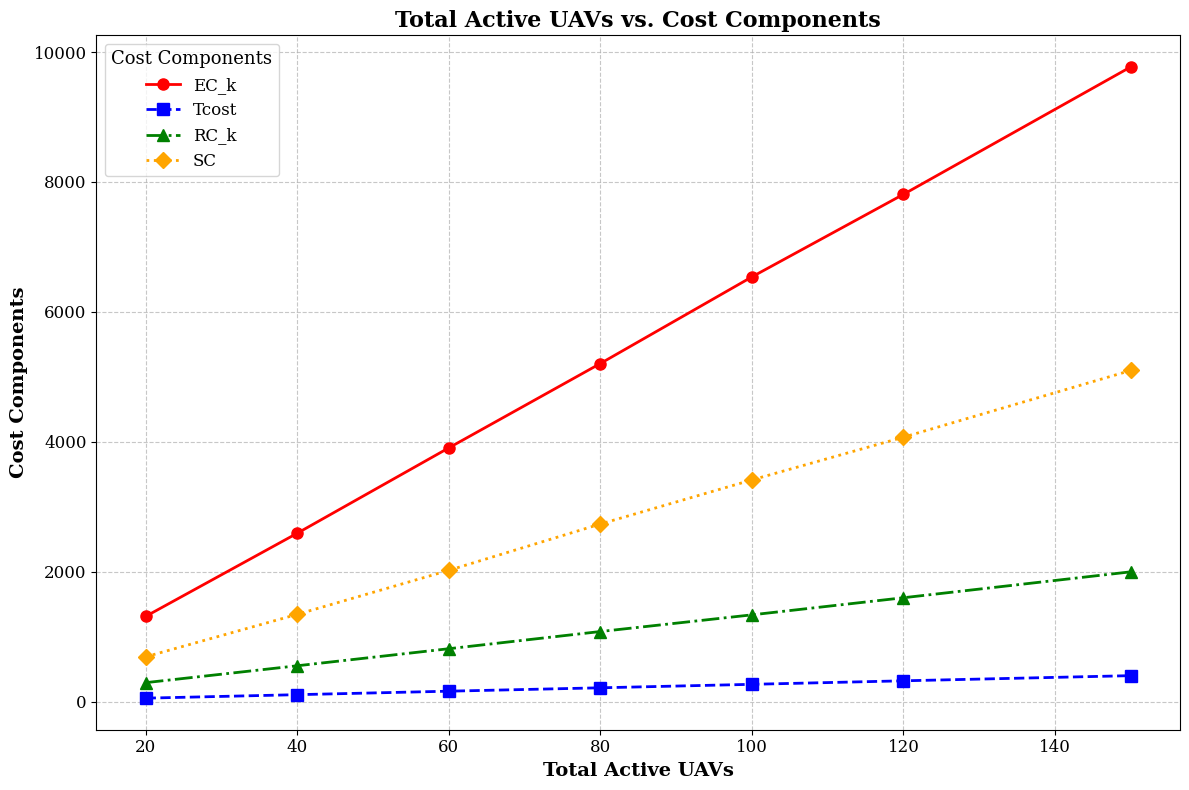

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import rcParams

# Attempt to set "Times New Roman" font
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman'] + rcParams['font.serif']

# Load the Excel file (adjust path as necessary)
file_path = '/content/drive/MyDrive/MTP/Results/Paper_1/NewResults/output_100Trials.xlsx'
res_df = pd.read_excel(file_path, sheet_name='Sheet_name_1')

# Convert relevant columns to numeric
res_df[['Total Active UAV', 'Total Active Sensors', 'EC_k', 'Tcost', 'RC_k', 'SC', 'Cost Price']] = res_df[['Total Active UAV', 'Total Active Sensors', 'EC_k', 'Tcost', 'RC_k', 'SC', 'Cost Price']].apply(pd.to_numeric)

# Filter out rows where 'Total Active UAV' is 0
res_df = res_df[res_df['Total Active UAV'] != 0]

# Group the data by 'Total Active UAV' and calculate the mean of relevant columns
grouped_data = res_df.groupby('Total Active UAV')[['EC_k', 'Tcost', 'RC_k', 'SC']].mean().reset_index()
from IPython.display import display, Math

# Define different markers, line styles, and colors for each cost component
markers = ['o', 's', '^', 'D']
line_styles = ['-', '--', '-.', ':']
colors = ['red', 'blue', 'green', 'orange']
labels = ['EC_k', 'Tcost', 'RC_k', 'SC']

# Create the plot
plt.figure(figsize=(12, 8))

# Plot each cost component with different markers, line styles, and colors
for marker, line_style, color, label in zip(markers, line_styles, colors, labels):
    plt.plot(grouped_data['Total Active UAV'], grouped_data[label], marker=marker, linestyle=line_style, color=color, linewidth=2, markersize=8, label=label)

# Enhance plot
plt.xlabel('Total Active UAVs', fontsize=14, fontweight='bold')
plt.ylabel('Cost Components', fontsize=14, fontweight='bold')
plt.title('Total Active UAVs vs. Cost Components', fontsize=16, fontweight='bold')
plt.legend(title='Cost Components', fontsize=12, title_fontsize='13')
plt.grid(True, linestyle='--', alpha=0.7)

# Additional styling
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()


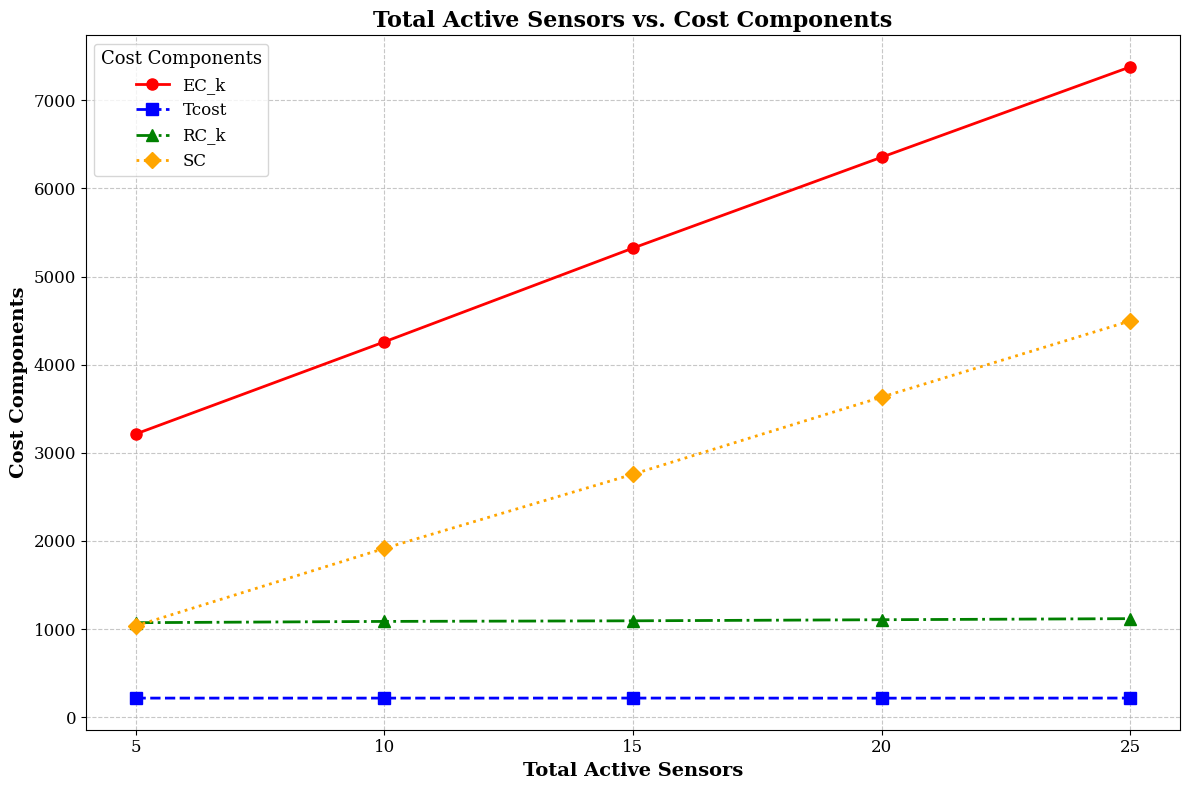

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Attempt to set "Times New Roman" font
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman'] + rcParams['font.serif']

# Convert relevant columns to numeric
res_df[['Total Active Sensors', 'EC_k', 'Tcost', 'RC_k', 'SC']] = res_df[['Total Active Sensors', 'EC_k', 'Tcost', 'RC_k', 'SC']].apply(pd.to_numeric)

# Group the data by 'Total Active Sensors' and calculate the mean of relevant columns
grouped_sensors = res_df.groupby('Total Active Sensors')[['EC_k', 'Tcost', 'RC_k', 'SC']].mean().reset_index()

# Create a line plot for each cost component
plt.figure(figsize=(12, 8))

# Define different markers and line styles for each cost component
markers = ['o', 's', '^', 'D']
line_styles = ['-', '--', '-.', ':']
colors = ['red', 'blue', 'green', 'orange']
labels = ['EC_k', 'Tcost', 'RC_k', 'SC']

# Plot each cost component with different markers and line styles
for marker, line_style, color, label in zip(markers, line_styles, colors, labels):
    plt.plot(grouped_sensors['Total Active Sensors'], grouped_sensors[label], marker=marker, linestyle=line_style, color=color, linewidth=2, markersize=8, label=label)

# Enhance plot
plt.xlabel('Total Active Sensors', fontsize=14, fontweight='bold')
plt.ylabel('Cost Components', fontsize=14, fontweight='bold')
plt.title('Total Active Sensors vs. Cost Components', fontsize=16, fontweight='bold')
plt.legend(title='Cost Components', fontsize=12, title_fontsize='13')
plt.grid(True, linestyle='--', alpha=0.7)

# Additional styling
plt.xticks([5, 10, 15, 20, 25], fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import math
from matplotlib import rcParams

# Attempt to set "Times New Roman" font
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman'] + rcParams['font.serif']

# Assuming res_df is your DataFrame
# Convert relevant columns to numeric
res_df[['Total Active Sensors', 'EC_k', 'Tcost', 'RC_k', 'SC']] = res_df[['Total Active Sensors', 'EC_k', 'Tcost', 'RC_k', 'SC']].apply(pd.to_numeric)

def get_total_expense(EC_k, Tcost, RC_k, SC):
    return EC_k + Tcost + RC_k + SC

def get_total_profit(total_chargeable_price, total_expense):
    return total_chargeable_price - total_expense

def get_total_chargeable_price(EC_k, Tcost, RC_k, SC):
    # Adding a profit margin to the total cost
    profit_margin = 0.1  # Example 10% profit margin
    return (EC_k + Tcost + RC_k + SC) * (1 + profit_margin)

PT_max = 10000
def get_utility_function(total_chargeable_price, total_profit, PT_max):
    # Handling the case where total_profit is zero to avoid math domain error
    if total_profit <= 0:
        return 0  # Or any appropriate value for this scenario
    PT_k = total_profit / PT_max
    return (total_chargeable_price * (1 - abs(math.log10(PT_k)))) / PT_max

for index, row in res_df.iterrows():
    EC_k = row['EC_k']
    Tcost = row['Tcost']
    RC_k = row['RC_k']
    SC = row['SC']

total_expense = get_total_expense(EC_k, Tcost, RC_k, SC)
total_chargeable_price = get_total_chargeable_price(EC_k, Tcost, RC_k, SC)
total_profit = get_total_profit(total_chargeable_price, total_expense)
utility_function_value = get_utility_function(total_chargeable_price, total_profit, PT_max)

print(f"Total Expense: {total_expense}")
print(f"Total Chargeable Price: {total_chargeable_price}")
print(f"Total Profit: {total_profit}")


Total Expense: 25551.721778242936
Total Chargeable Price: 28106.893956067233
Total Profit: 2555.1721778242973


<ipython-input-3-c81a378fa5fa>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_profit[total_profit <= 0] = 1e-10  # Avoiding zero or negative values for log10


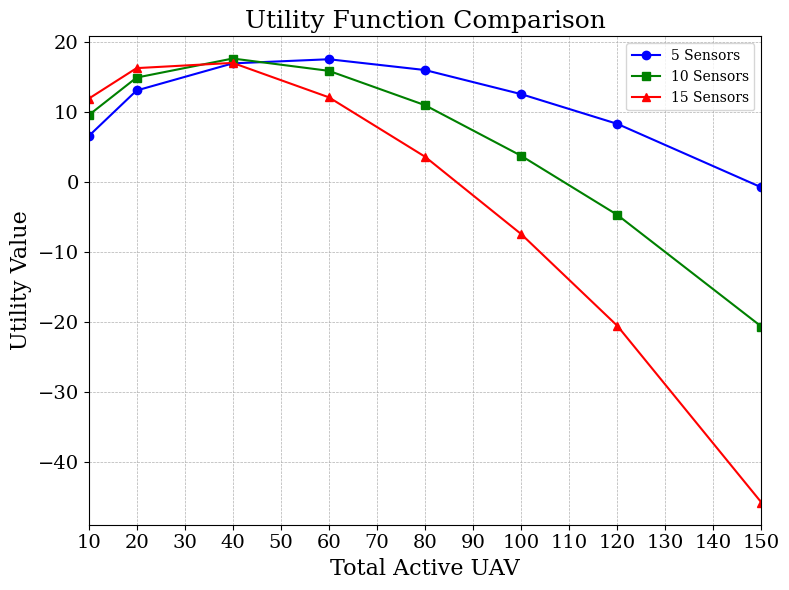

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import rcParams

# Attempt to set "Times New Roman" font
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman'] + rcParams['font.serif']

# Define the functions for calculations
def get_total_expense(EC_k, Tcost, RC_k, SC):
    return EC_k + Tcost + RC_k + SC

def get_total_profit(total_chargeable_price, total_expense):
    return total_chargeable_price - total_expense

def get_total_chargeable_price(EC_k, Tcost, RC_k, SC):
    profit_margin = 0.1  # Example 10% profit margin
    return (EC_k + Tcost + RC_k + SC) * (1 + profit_margin)

def get_utility_function(total_chargeable_price, total_profit, PT_max):
    total_profit[total_profit <= 0] = 1e-10  # Avoiding zero or negative values for log10
    PT_k = total_profit / PT_max
    return (total_chargeable_price * (1 - np.abs(np.log10(PT_k)))) / PT_max

# Load the Excel file (adjust path as necessary)
file_path = '/content/drive/MyDrive/MTP/Results/Paper_1/NewResults/output_100Trials.xlsx'
res_df = pd.read_excel(file_path, sheet_name='Sheet_name_1')

# Filter data for sensors = 5, 10, and 15
sensors_list = [5, 10, 15]
selected_data = res_df[res_df['Total Active Sensors'].isin(sensors_list)]

# Group data by number of UAVs and calculate mean values
grouped_data = selected_data.groupby(['Total Active UAV', 'Total Active Sensors']).mean().reset_index()

# Calculate total expense, total chargeable price, total profit, and utility function value
grouped_data['Total Expense'] = get_total_expense(grouped_data['EC_k'], grouped_data['Tcost'], grouped_data['RC_k'], grouped_data['SC'])
grouped_data['Total Chargeable Price'] = get_total_chargeable_price(grouped_data['EC_k'], grouped_data['Tcost'], grouped_data['RC_k'], grouped_data['SC'])
grouped_data['Total Profit'] = get_total_profit(grouped_data['Total Chargeable Price'], grouped_data['Total Expense'])
grouped_data['Utility Function Value'] = get_utility_function(grouped_data['Total Chargeable Price'], grouped_data['Total Profit'], PT_max=100)  # Assuming PT_max value

# Create a smaller figure with a single plot
fig, ax = plt.subplots(figsize=(8, 6))  # Adjusted smaller size

# Define markers and colors for each sensor count
markers = ['o', 's', '^']
colors = ['b', 'g', 'r']
labels = ['5 Sensors', '10 Sensors', '15 Sensors']

# Loop through each sensor count, plot the utility function against Total Active UAV
for idx, sensors in enumerate(sensors_list):
    subset_data = grouped_data[grouped_data['Total Active Sensors'] == sensors]
    ax.plot(subset_data['Total Active UAV'], subset_data['Utility Function Value'], marker=markers[idx], linestyle='-', color=colors[idx], label=labels[idx])

# Set labels, title, grid, and legend for the plot
ax.set_xlabel('Total Active UAV', fontsize=16)
ax.set_ylabel('Utility Value', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)  # Adjust tick label font size
ax.set_title('Utility Function Comparison', fontsize=18)
ax.grid(True, linestyle='--', linewidth=0.5)
ax.legend()

# Set x-axis ticks and limits
ax.set_xticks(range(10, 151, 10))  # x-axis ticks from 10 to 150 with interval of 10
ax.set_xlim([10, 150])  # Limit x-axis range to 10-150

# Adjust layout and display plot
plt.tight_layout()
plt.show()


<ipython-input-4-aebca839b126>:47: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.8.
  ax.bar(mean_values.index + i * bar_width - 1.5 * bar_width, mean_values, bar_width, label=col, hatch=pattern, alpha=0.8, color=color, edgecolor='black', yerr=ci95_values)


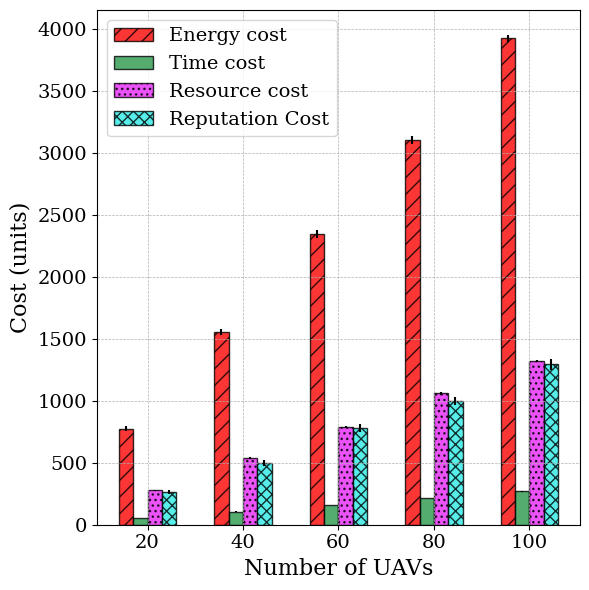

<ipython-input-4-aebca839b126>:47: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.8.
  ax.bar(mean_values.index + i * bar_width - 1.5 * bar_width, mean_values, bar_width, label=col, hatch=pattern, alpha=0.8, color=color, edgecolor='black', yerr=ci95_values)


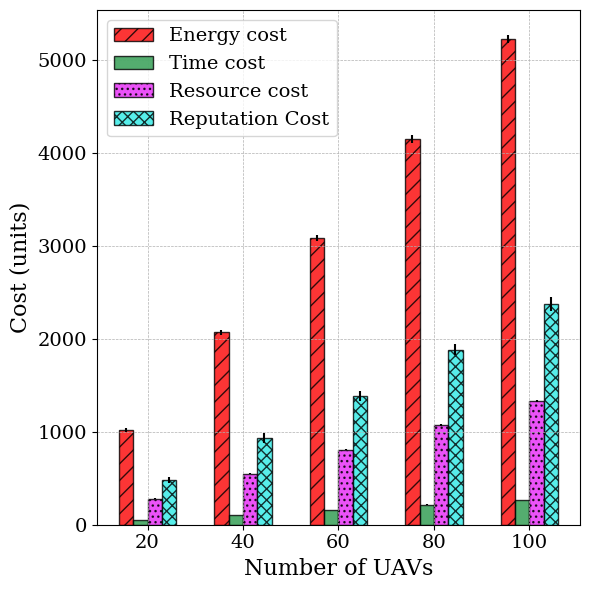

<ipython-input-4-aebca839b126>:47: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.8.
  ax.bar(mean_values.index + i * bar_width - 1.5 * bar_width, mean_values, bar_width, label=col, hatch=pattern, alpha=0.8, color=color, edgecolor='black', yerr=ci95_values)


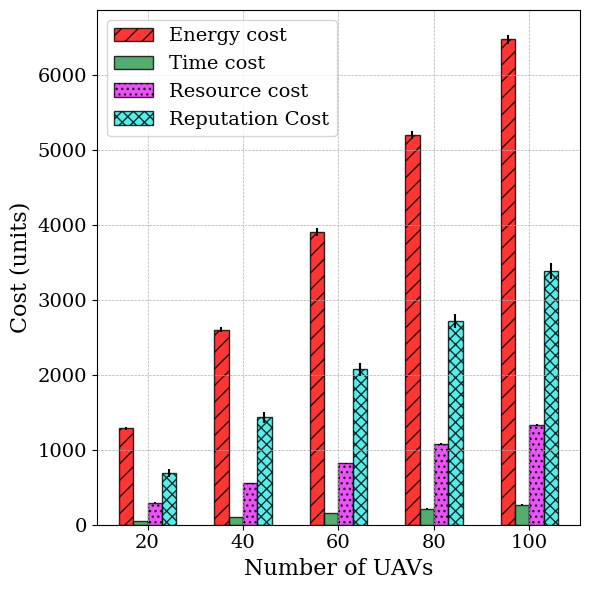

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams

file_path = '/content/drive/MyDrive/MTP/Results/Paper_1/NewResults/output_100Trials.xlsx'
df = pd.read_excel(file_path, sheet_name='Sheet_name_1')

# Attempt to set "Times New Roman" font
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman'] + rcParams['font.serif']

# Define the UAV counts to plot on x-axis (including 100)
uav_counts = [20, 40, 60, 80, 100]

# Define the sensor counts for each subplot
sensor_counts = [5, 10, 15]

# Adjust bar width and patterns for better visualization
bar_width = 3  # Increased bar width
patterns = ('//', ' ', '...', 'xxx')  # No pattern for Tcost
colors = ['#FC0202', '#29994B', '#E727F7', '#2DEAE5', '#1f77b4']

# Custom legend labels
legend_labels = ['Energy cost', 'Time cost', 'Resource cost', 'Reputation Cost']

# Function to calculate 95% confidence interval
def ci95(sem):
    return 1.96 * sem

# Iterate over each sensor count and plot
for sensors in sensor_counts:
    fig, ax = plt.subplots(figsize=(6, 6))
    subset = df[df['Total Active Sensors'] == sensors]

    # Filter data for all uav_counts
    filtered_data = subset[subset['Total Active UAV'].isin(uav_counts)]

    # Calculate means and SEMs
    means = filtered_data.groupby('Total Active UAV').mean().reindex(uav_counts)
    sems = filtered_data.groupby('Total Active UAV').sem().reindex(uav_counts)

    # Plot the bar graph for each cost component with patterns
    for i, (col, pattern, color) in enumerate(zip(['EC_k', 'Tcost', 'RC_k', 'SC'], patterns, colors)):
        mean_values = means[col]
        sem_values = sems[col]
        ci95_values = ci95(sem_values)
        ax.bar(mean_values.index + i * bar_width - 1.5 * bar_width, mean_values, bar_width, label=col, hatch=pattern, alpha=0.8, color=color, edgecolor='black', yerr=ci95_values)

    # Customize plot properties
    ax.set_xlabel('Number of UAVs', fontsize=16)
    ax.set_ylabel('Cost (units)', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)  # Adjust tick label font size
    ax.set_xticks(uav_counts)
    ax.grid(True, linestyle='--', linewidth=0.5)

    # Create a legend for the subplot in the upper left corner with custom labels
    ax.legend(legend_labels, loc='upper left', fontsize=14)

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()


<ipython-input-5-2586dd537bfe>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_profit[total_profit <= 0] = 1e-10  # Avoiding zero or negative values for log10


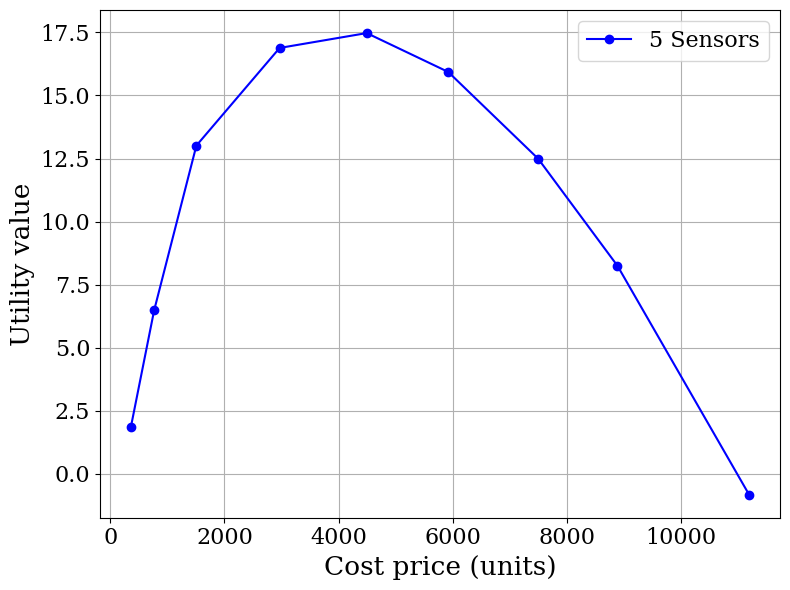

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import rcParams

# Attempt to set "Times New Roman" font
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman'] + rcParams['font.serif']

# Define the functions for calculations
def get_total_expense(EC_k, Tcost, RC_k, SC):
    return EC_k + Tcost + RC_k + SC

def get_total_profit(total_chargeable_price, total_expense):
    return total_chargeable_price - total_expense

def get_total_chargeable_price(EC_k, Tcost, RC_k, SC):
    profit_margin = 0.1  # Example 10% profit margin
    return (EC_k + Tcost + RC_k + SC) * (1 + profit_margin)

def get_utility_function(total_chargeable_price, total_profit, PT_max):
    total_profit[total_profit <= 0] = 1e-10  # Avoiding zero or negative values for log10
    PT_k = total_profit / PT_max
    return (total_chargeable_price * (1 - np.abs(np.log10(PT_k)))) / PT_max

# Load the Excel file (adjust path as necessary)
file_path = '/content/drive/MyDrive/MTP/Results/Paper_1/NewResults/output_100Trials.xlsx'
res_df = pd.read_excel(file_path, sheet_name='Sheet_name_1')

# Filter data for sensors = 5
sensors = 5
selected_data = res_df[res_df['Total Active Sensors'] == sensors]

# Group data by number of UAVs and calculate mean values
grouped_data = selected_data.groupby(['Total Active UAV']).mean().reset_index()

# Calculate total expense, total chargeable price, total profit, and utility function value
grouped_data['Total Expense'] = get_total_expense(grouped_data['EC_k'], grouped_data['Tcost'], grouped_data['RC_k'], grouped_data['SC'])
grouped_data['Total Chargeable Price'] = get_total_chargeable_price(grouped_data['EC_k'], grouped_data['Tcost'], grouped_data['RC_k'], grouped_data['SC'])
grouped_data['Total Profit'] = get_total_profit(grouped_data['Total Chargeable Price'], grouped_data['Total Expense'])
grouped_data['Utility Function Value'] = get_utility_function(grouped_data['Total Chargeable Price'], grouped_data['Total Profit'], PT_max=100)  # Assuming PT_max value

# Plotting utility function vs cost price for Sensors = 5
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
plt.plot(grouped_data['Total Chargeable Price'], grouped_data['Utility Function Value'], marker='o', linestyle='-', color='blue', label=f'{sensors} Sensors')
plt.xlabel('Cost price (units)', fontsize=19)
plt.ylabel('Utility value', fontsize=19)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()


<ipython-input-5-2586dd537bfe>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_profit[total_profit <= 0] = 1e-10  # Avoiding zero or negative values for log10


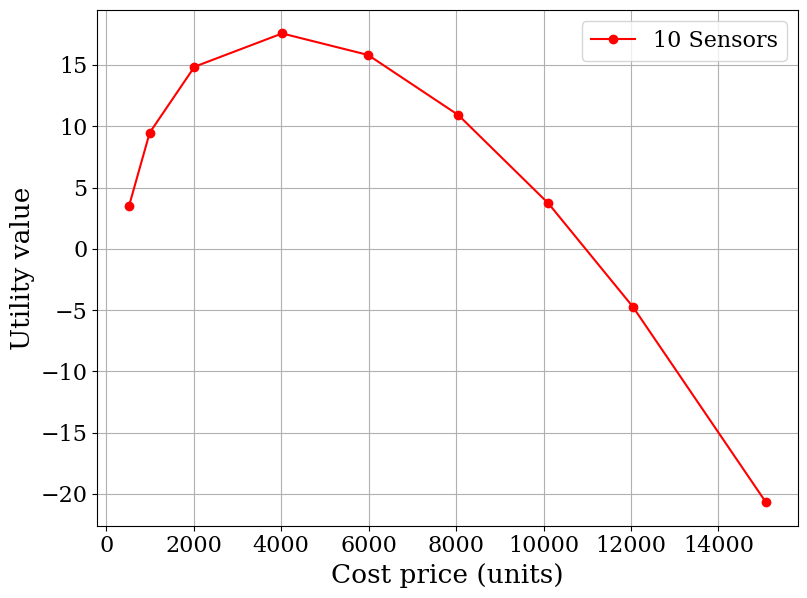

In [6]:
# Filter data for sensors = 10
sensors = 10
selected_data = res_df[res_df['Total Active Sensors'] == sensors]

# Group data by number of UAVs and calculate mean values
grouped_data = selected_data.groupby(['Total Active UAV']).mean().reset_index()

# Calculate total expense, total chargeable price, total profit, and utility function value
grouped_data['Total Expense'] = get_total_expense(grouped_data['EC_k'], grouped_data['Tcost'], grouped_data['RC_k'], grouped_data['SC'])
grouped_data['Total Chargeable Price'] = get_total_chargeable_price(grouped_data['EC_k'], grouped_data['Tcost'], grouped_data['RC_k'], grouped_data['SC'])
grouped_data['Total Profit'] = get_total_profit(grouped_data['Total Chargeable Price'], grouped_data['Total Expense'])
grouped_data['Utility Function Value'] = get_utility_function(grouped_data['Total Chargeable Price'], grouped_data['Total Profit'], PT_max=100)  # Assuming PT_max value

# Plotting utility function vs cost price for Sensors = 10
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
plt.plot(grouped_data['Total Chargeable Price'], grouped_data['Utility Function Value'], marker='o', linestyle='-', color='red', label=f'{sensors} Sensors')
plt.xlabel('Cost price (units)',fontsize=19)
plt.ylabel('Utility value',fontsize=19)

plt.grid(True)
plt.legend(fontsize=16)
plt.tight_layout()

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

<ipython-input-5-2586dd537bfe>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_profit[total_profit <= 0] = 1e-10  # Avoiding zero or negative values for log10


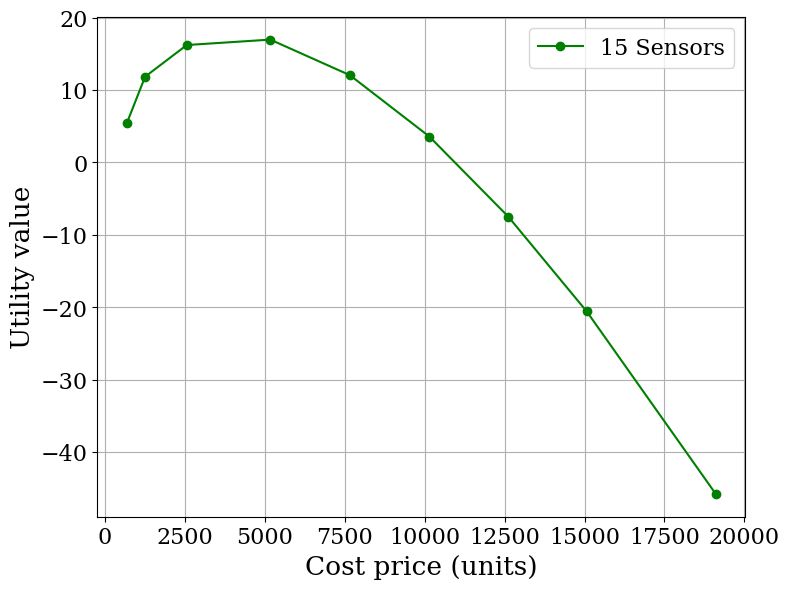

In [7]:
# Filter data for sensors = 15
sensors = 15
selected_data = res_df[res_df['Total Active Sensors'] == sensors]

# Group data by number of UAVs and calculate mean values
grouped_data = selected_data.groupby(['Total Active UAV']).mean().reset_index()

# Calculate total expense, total chargeable price, total profit, and utility function value
grouped_data['Total Expense'] = get_total_expense(grouped_data['EC_k'], grouped_data['Tcost'], grouped_data['RC_k'], grouped_data['SC'])
grouped_data['Total Chargeable Price'] = get_total_chargeable_price(grouped_data['EC_k'], grouped_data['Tcost'], grouped_data['RC_k'], grouped_data['SC'])
grouped_data['Total Profit'] = get_total_profit(grouped_data['Total Chargeable Price'], grouped_data['Total Expense'])
grouped_data['Utility Function Value'] = get_utility_function(grouped_data['Total Chargeable Price'], grouped_data['Total Profit'], PT_max=100)  # Assuming PT_max value

# Plotting utility function vs cost price for Sensors = 15
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
plt.plot(grouped_data['Total Chargeable Price'], grouped_data['Utility Function Value'], marker='o', linestyle='-', color='green', label=f'{sensors} Sensors')
plt.xlabel('Cost price (units)',fontsize=19)
plt.ylabel('Utility value',fontsize=19)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()


<ipython-input-8-c9b0701bbdf7>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_profit[total_profit <= 0] = 1e-10  # Avoiding zero or negative values for log10
<ipython-input-8-c9b0701bbdf7>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_profit[total_profit <= 0] = 1e-10  # Avoiding zero or negative values for log10
<ipython-input-8-c9b0701bbdf7>:73: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.8.
  ax.bar(bar_positions, filtered_grouped_data[

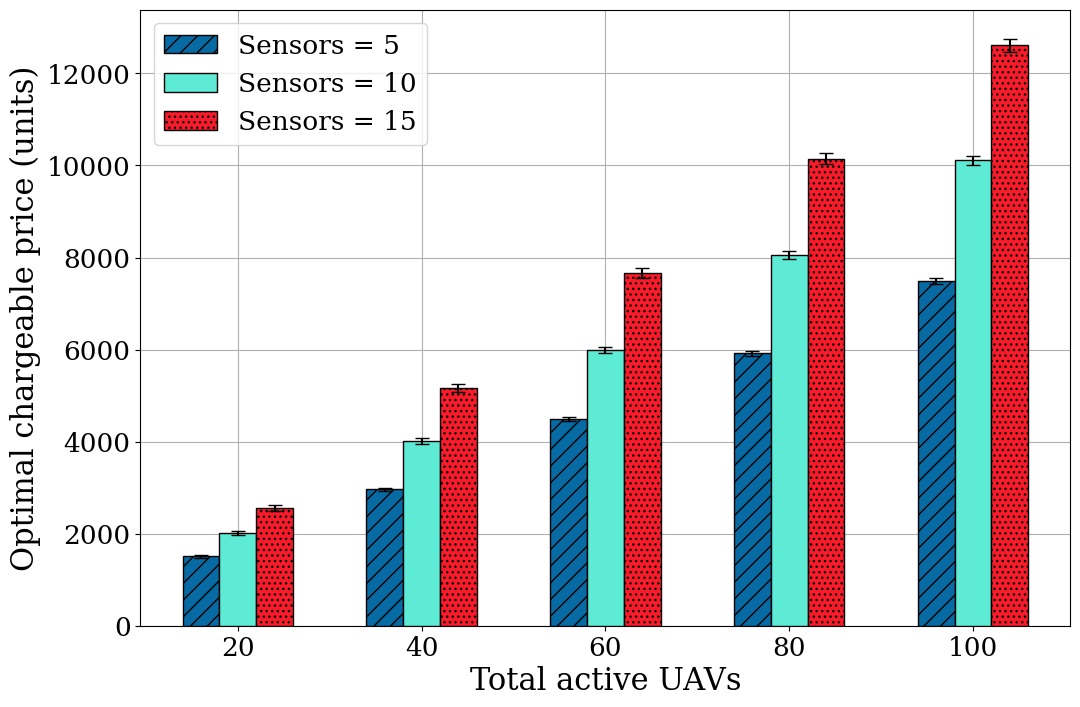

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.stats import sem, t

# Set "Times New Roman" font
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman'] + rcParams['font.serif']

# Load the data from the Excel file
file_path = '/content/drive/MyDrive/MTP/Results/Paper_1/NewResults/output_100Trials.xlsx'
df = pd.read_excel(file_path, sheet_name='Sheet_name_1')

# Convert columns to numeric if necessary
df[['Total Active UAV', 'EC_k', 'Tcost', 'RC_k', 'SC']] = df[['Total Active UAV', 'EC_k', 'Tcost', 'RC_k', 'SC']].apply(pd.to_numeric)
profit_margin = 0.1
sensor_counts = [5, 10, 15]
uav_numbers = [20, 40, 60, 80, 100]

# Define the functions
def get_total_expense(EC_k, Tcost, RC_k, SC):
    return EC_k + Tcost + RC_k + SC

def get_total_profit(total_chargeable_price, total_expense):
    return total_chargeable_price - total_expense

def get_total_chargeable_price(EC_k, Tcost, RC_k, SC):
    profit_margin = 0.1  # Example 10% profit margin
    return (EC_k + Tcost + RC_k + SC) * (1 + profit_margin)

def get_utility_function(total_chargeable_price, total_profit, PT_max):
    total_profit[total_profit <= 0] = 1e-10  # Avoiding zero or negative values for log10
    PT_k = total_profit / PT_max
    return (total_chargeable_price * (1 - np.abs(np.log10(PT_k)))) / PT_max

# Function to calculate the optimal chargeable price for different UAV numbers
def calculate_optimal_chargeable_price(df, sensors):
    selected_data = df[df['Total Active Sensors'] == sensors]
    grouped_data = selected_data.groupby(['Total Active UAV']).agg(
        EC_k=('EC_k', 'mean'),
        Tcost=('Tcost', 'mean'),
        RC_k=('RC_k', 'mean'),
        SC=('SC', 'mean'),
        EC_k_sem=('EC_k', sem),
        Tcost_sem=('Tcost', sem),
        RC_k_sem=('RC_k', sem),
        SC_sem=('SC', sem)
    ).reset_index()
    grouped_data['Total Expense'] = get_total_expense(grouped_data['EC_k'], grouped_data['Tcost'], grouped_data['RC_k'], grouped_data['SC'])
    grouped_data['Total Chargeable Price'] = get_total_chargeable_price(grouped_data['EC_k'], grouped_data['Tcost'], grouped_data['RC_k'], grouped_data['SC'])
    grouped_data['Total Profit'] = get_total_profit(grouped_data['Total Chargeable Price'], grouped_data['Total Expense'])
    grouped_data['Utility Function Value'] = get_utility_function(grouped_data['Total Chargeable Price'], grouped_data['Total Profit'], PT_max=100)  # Assuming PT_max value

    # Calculate the 95% confidence interval
    grouped_data['Total Expense_sem'] = np.sqrt(grouped_data['EC_k_sem']**2 + grouped_data['Tcost_sem']**2 + grouped_data['RC_k_sem']**2 + grouped_data['SC_sem']**2)
    ci_multiplier = t.ppf(0.975, len(selected_data) - 1)
    grouped_data['Total Chargeable Price_ci'] = ci_multiplier * grouped_data['Total Expense_sem'] * (1 + profit_margin)

    return grouped_data

# Plotting function
def plot_optimal_chargeable_price_vs_uav_numbers(df, sensor_counts, uav_numbers):
    bar_width = 0.2
    colors = ['#076aa3', '#5eebd5', '#fa1b2a']  # Colors for the bars
    hatches = ['///', '...', 'xxx']  # Hatches for the bars
    fig, ax = plt.subplots(figsize=(12, 8))

    for i, sensors in enumerate(sensor_counts):
        grouped_data = calculate_optimal_chargeable_price(df, sensors)
        filtered_grouped_data = grouped_data[grouped_data['Total Active UAV'].isin(uav_numbers)]
        bar_positions = np.arange(len(uav_numbers)) + i * bar_width
        ax.bar(bar_positions, filtered_grouped_data['Total Chargeable Price'], yerr=filtered_grouped_data['Total Chargeable Price_ci'], width=bar_width, color=colors[i], edgecolor='black', label=f'Sensors = {sensors}', hatch=patterns[i], capsize=5,zorder=3)

    ax.set_xlabel('Total active UAVs', fontsize=22)
    ax.set_ylabel('Optimal chargeable price (units)', fontsize=22)
    plt.xticks(fontsize=19)
    plt.yticks(fontsize=19)
    ax.set_xticks(np.arange(len(uav_numbers)) + bar_width)
    ax.set_xticklabels(uav_numbers)
    ax.legend(fontsize=19)
    ax.grid(True,zorder=0)
    plt.show()

# Plot the results
plot_optimal_chargeable_price_vs_uav_numbers(df, sensor_counts, uav_numbers)


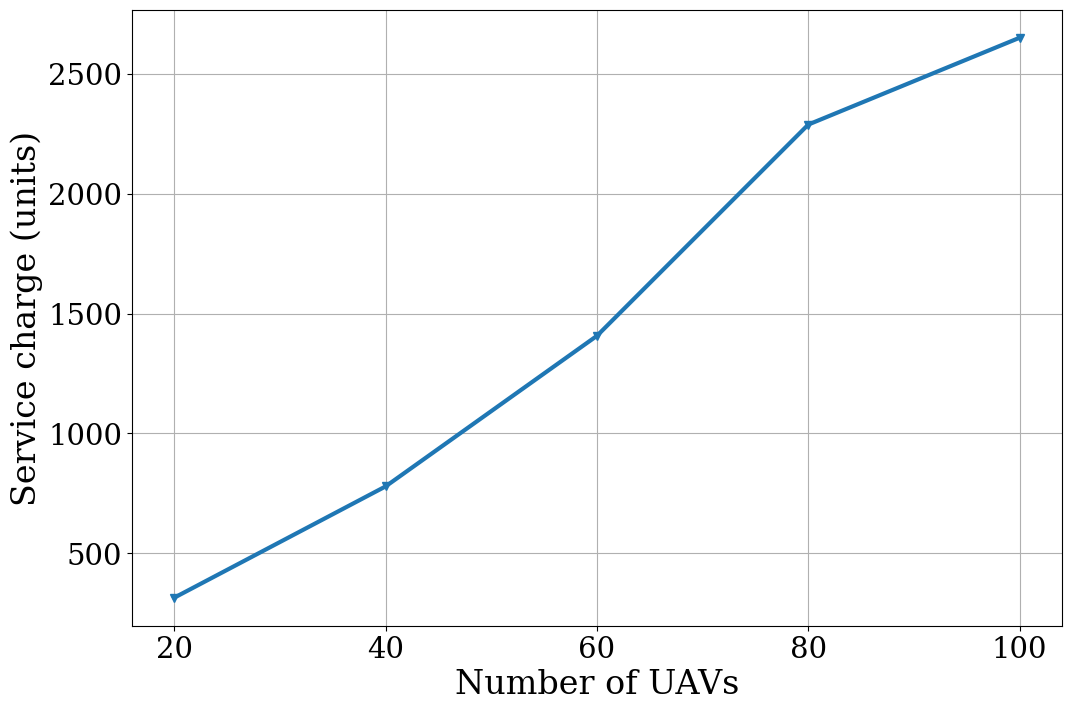

In [9]:
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
from matplotlib import rcParams

# Attempt to set "Times New Roman" font
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman'] + rcParams['font.serif']

# Set a fixed seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)

# Load the data from the Excel file
file_path = '/content/drive/MyDrive/MTP/Results/Paper_1/NewResults/output_100Trials.xlsx'
df = pd.read_excel(file_path, sheet_name='Sheet_name_1')
df[['Total Active UAV', 'EC_k', 'Tcost', 'RC_k', 'SC']] = df[['Total Active UAV', 'EC_k', 'Tcost', 'RC_k', 'SC']].apply(pd.to_numeric)
# Constants
Ti_Max = 10
Tp = [0, 10]
Area_Tt = [5, 15]
Area_Cov = [5, 15]
CSc = 1
Total_Tt = [0.10, 6]
Taken_Tt = [0.10, 6]

def get_service_charge(x, n):
    total_feedbacks = Ti_Max
    uav_reputation_coff = 0

    for each_uav in range(x):
        uav_positive_feedback_count = random.randint(Tp[0], total_feedbacks)
        ComRF = uav_positive_feedback_count / total_feedbacks

        CovRF_bar = 0
        curr_uav_active_sensor_count = random.randint(1, n)
        curr_uav_CovRF = 0
        for each_sensor_curr_uav in range(curr_uav_active_sensor_count):
            total_cov_area = random.randint(Area_Tt[0], Area_Tt[1])
            actual_cov_area = random.randint(Area_Cov[0], total_cov_area)
            CovRF_j = actual_cov_area / total_cov_area
            curr_uav_CovRF += CovRF_j

        CovRF_bar = curr_uav_CovRF / curr_uav_active_sensor_count
        Rep_factor = ComRF + CovRF_bar

        total_time = random.uniform(Total_Tt[0], Total_Tt[1])
        taken_time = random.uniform(Taken_Tt[0], total_time)
        Tprod_i = taken_time / total_time

        curr_rep_coff = (Rep_factor * curr_uav_active_sensor_count) / Tprod_i
        uav_reputation_coff += curr_rep_coff

    SC = CSc * uav_reputation_coff
    return SC

# Number of UAVs and sensor counts to consider
num_uavs = [20, 40, 60, 80, 100]
sensor_counts = [5, 10, 15]

# Data for plots
data = {sc: [] for sc in sensor_counts}

for sc in sensor_counts:
    for uav in num_uavs:
        service_charge = get_service_charge(uav, sc)
        data[sc].append(service_charge)

# Plotting only for sensor count = 10
plt.figure(figsize=(12, 8))
plt.plot(num_uavs, data[10], marker='v', linewidth=3)  # Increase linewidth to make the line bold

plt.xlabel('Number of UAVs', fontsize=24)
plt.ylabel('Service charge (units)', fontsize=24)

plt.xticks(num_uavs, fontsize=21)  # Only show specified x-axis values
plt.yticks(fontsize=21)
plt.grid(True)
plt.show()


In [10]:
import pandas as pd

# Load the data from the Excel file
file_path = '/content/drive/MyDrive/MTP/Results/Paper_1/NewResults/output_100Trials.xlsx'
res_df = pd.read_excel(file_path, sheet_name='Sheet_name_1')

# Convert columns to numeric if necessary
res_df[['Total Active UAV', 'EC_k', 'Tcost', 'RC_k', 'SC']] = res_df[['Total Active UAV', 'EC_k', 'Tcost', 'RC_k', 'SC']].apply(pd.to_numeric)

# Define the functions for calculations
def get_energy_based_cost(uavs, sensors, params):
    # Example placeholder function
    return pd.Series({'Ec_K': uavs * sensors * 0.5})

def get_time_based_cost(uavs):
    # Example placeholder function
    return pd.Series({'Tcost': uavs * 0.2})

def get_resource_based_cost(uavs, sensors):
    # Example placeholder function
    return pd.Series({'Rc_K': sensors * 0.3})

def get_reputation_based_cost_v2(uavs, sensors):
    # Example placeholder function
    return pd.Series({'SC': uavs * sensors * 0.1})

def get_CT_k(Ec_K, Tcost, Rc_K, SC):
    return Ec_K + Tcost + Rc_K + SC

def get_PT_k():
    # Example placeholder value
    return 100

def get_optimal_CT_k(CT_k, PT_k):
    # Example placeholder calculation
    profit_margin = 0.1  # 10% profit margin
    return CT_k * (1 + profit_margin)

# Calculate the optimal costs and add as a new column
optimal_costs = []

for index, row in res_df.iterrows():
    k = row['Total Active UAV']
    n = row['Total Active Sensors']

    energy_based_vals = get_energy_based_cost(k, n, [])
    time_based_vals = get_time_based_cost(k)
    resource_based_vals = get_resource_based_cost(k, n)
    reputation_based_cost = get_reputation_based_cost_v2(k, n)

    CT_k = get_CT_k(energy_based_vals['Ec_K'], time_based_vals['Tcost'], resource_based_vals['Rc_K'], reputation_based_cost['SC'])
    PT_k = get_PT_k()
    Cost_Price = get_optimal_CT_k(CT_k, PT_k)

    optimal_costs.append(Cost_Price)

res_df['Optimal Costs'] = optimal_costs

# Save the updated DataFrame to a new Excel file
output_file_path = '/content/drive/MyDrive/MTP/Results/Paper_1/NewResults/finalresult.xlsx'
res_df.to_excel(output_file_path, sheet_name='Sheet_name_1', index=False)



In [11]:
import pandas as pd

# Load your existing Excel file into a DataFrame
file_path = '/content/drive/MyDrive/MTP/Results/Paper_1/NewResults/finalresult.xlsx'
df = pd.read_excel(file_path, sheet_name='Sheet_name_1')

# Function to calculate total profit
def get_total_profit(total_chargeable_price, total_expense):
    return total_chargeable_price - total_expense

# Function to calculate total chargeable price
def get_total_chargeable_price(EC_k, Tcost, RC_k, SC):
    profit_margin = 0.1  # Example 10% profit margin
    return (EC_k + Tcost + RC_k + SC) * (1 + profit_margin)

# Calculate total chargeable price, total expense, and total profit
df['Total Chargeable Price'] = df.apply(lambda row: get_total_chargeable_price(row['EC_k'], row['Tcost'], row['RC_k'], row['SC']), axis=1)
df['Total Expense'] = df['EC_k'] + df['Tcost'] + df['RC_k'] + df['SC']
df['Total Profit'] = df.apply(lambda row: get_total_profit(row['Total Chargeable Price'], row['Total Expense']), axis=1)

# Save the updated DataFrame to the same Excel file
df.to_excel(file_path, sheet_name='Sheet_name_1', index=False)

print(df)  # Optionally, print the DataFrame to verify


      Total Active UAV  Total Active Sensors          EC_k       Tcost  \
0                    5                     5    273.478950   15.323837   
1                    5                    10    215.279349   16.073323   
2                    5                    15    352.178971   15.655674   
3                    5                    20    462.739269    8.645034   
4                    5                    25    317.165017   16.302816   
...                ...                   ...           ...         ...   
4495               150                     5   6271.240103  397.084048   
4496               150                    10   8213.515780  410.009214   
4497               150                    15   9985.705235  427.106247   
4498               150                    20  11616.082328  406.951961   
4499               150                    25  13784.410589  366.973101   

             RC_k           SC    Cost Price  Optimal Costs  \
0       80.183705    57.655630    426.642121    

In [12]:
import pandas as pd
import numpy as np

# Define the functions for calculations
def get_total_expense(EC_k, Tcost, RC_k, SC):
    return EC_k + Tcost + RC_k + SC

def get_total_profit(total_chargeable_price, total_expense):
    return total_chargeable_price - total_expense

def get_total_chargeable_price(EC_k, Tcost, RC_k, SC):
    profit_margin = 0.1  # Example 10% profit margin
    return (EC_k + Tcost + RC_k + SC) * (1 + profit_margin)

def get_utility_function(total_chargeable_price, total_profit, PT_max):
    total_profit[total_profit <= 0] = 1e-10  # Avoiding zero or negative values for log10
    PT_k = total_profit / PT_max
    return (total_chargeable_price * (1 - np.abs(np.log10(PT_k)))) / PT_max

# Load the Excel file (adjust path as necessary)
excel_file = '/content/drive/MyDrive/MTP/Results/Paper_1/NewResults/finalresult.xlsx'
res_df = pd.read_excel(excel_file, sheet_name='Sheet_name_1')

# Assuming grouped_data is your DataFrame with calculated values
# Calculate total expense, total chargeable price, total profit, and utility function value
res_df['Total Expense'] = get_total_expense(res_df['EC_k'], res_df['Tcost'], res_df['RC_k'], res_df['SC'])
res_df['Total Chargeable Price'] = get_total_chargeable_price(res_df['EC_k'], res_df['Tcost'], res_df['RC_k'], res_df['SC'])
res_df['Total Profit'] = get_total_profit(res_df['Total Chargeable Price'], res_df['Total Expense'])
res_df['Utility Function Value'] = get_utility_function(res_df['Total Chargeable Price'], res_df['Total Profit'], PT_max=100)  # Adjust PT_max as needed

# Save back to Excel
with pd.ExcelWriter(excel_file, engine='openpyxl') as writer:
    res_df.to_excel(writer, sheet_name='Sheet_name_1', index=False)

# Notify the user that the operation was successful
print(f'Data saved successfully to {excel_file}.')


<ipython-input-12-b40e2496492c>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_profit[total_profit <= 0] = 1e-10  # Avoiding zero or negative values for log10


Data saved successfully to /content/drive/MyDrive/MTP/Results/Paper_1/NewResults/finalresult.xlsx.


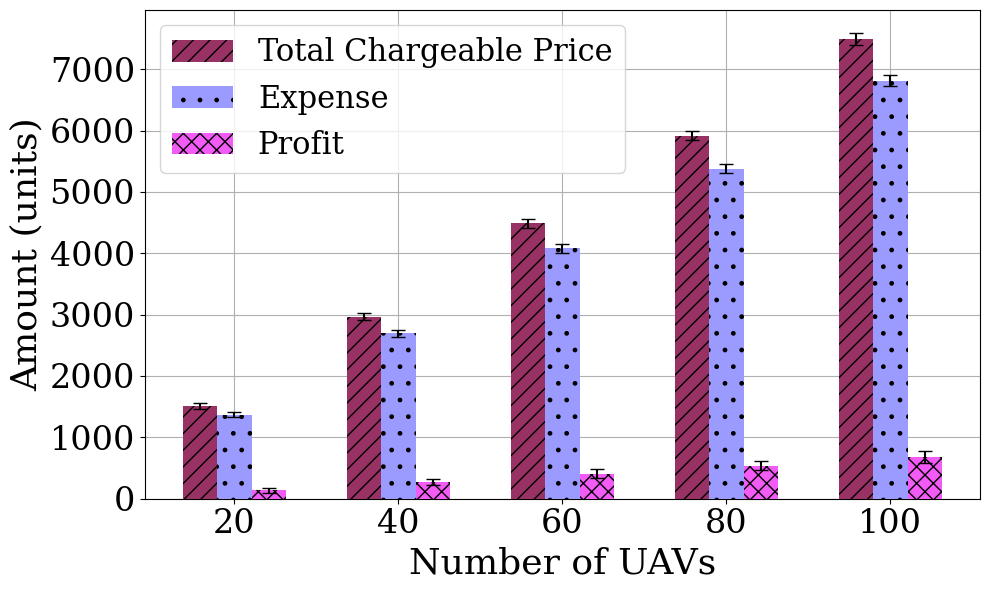

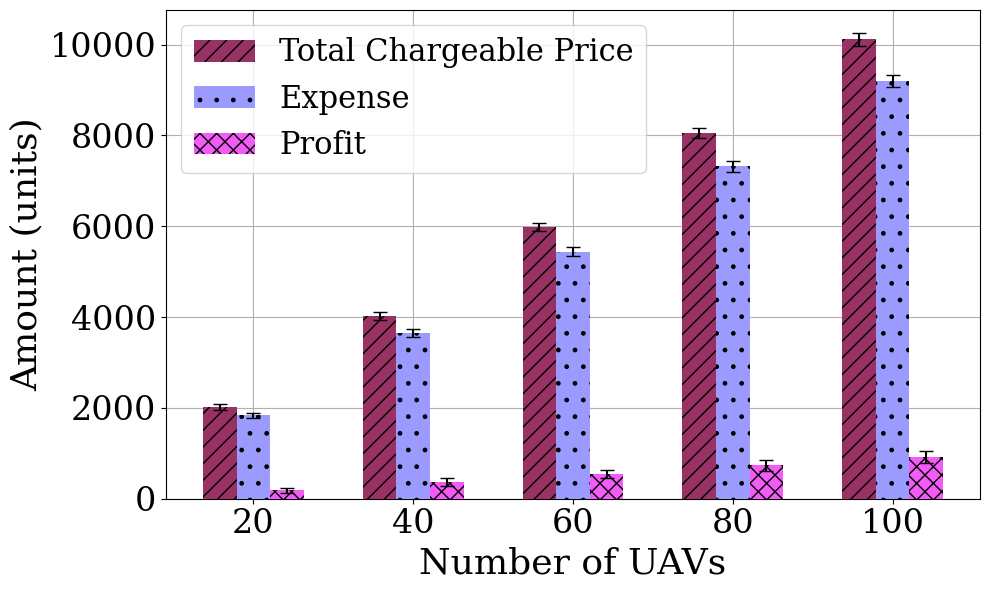

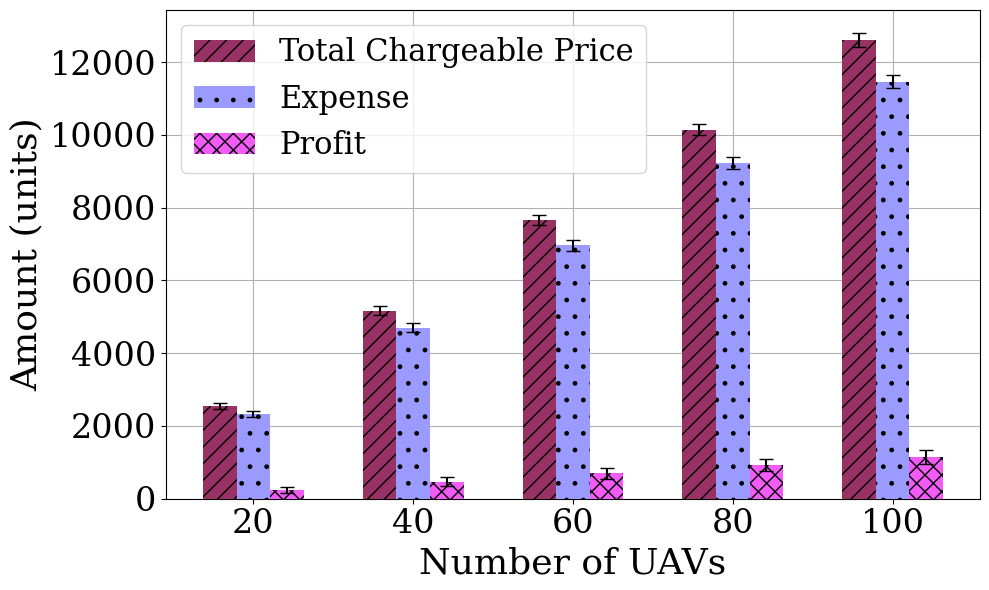

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import stats
import numpy as np

# Attempt to set "Times New Roman" font
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman'] + rcParams['font.serif']

# Load the data from the Excel file
file_path = '/content/drive/MyDrive/MTP/Results/Paper_1/NewResults/output_100Trials.xlsx'
df = pd.read_excel(file_path, sheet_name='Sheet_name_1')

# Convert columns to numeric if necessary
df[['Total Active UAV', 'Total Active Sensors', 'EC_k', 'Tcost', 'RC_k', 'SC']] = df[['Total Active UAV', 'Total Active Sensors', 'EC_k', 'Tcost', 'RC_k', 'SC']].apply(pd.to_numeric)

# Function to calculate total profit
def get_total_profit(total_chargeable_price, total_expense):
    return total_chargeable_price - total_expense

# Function to calculate total chargeable price
def get_total_chargeable_price(EC_k, Tcost, RC_k, SC):
    profit_margin = 0.1  # Example 10% profit margin
    return (EC_k + Tcost + RC_k + SC) * (1 + profit_margin)

# Filter data for sensor counts 5, 10, and 15
sensor_counts = [5, 10, 15]
colors = ['b', 'g', 'r']
patterns = ['//', '.', 'xxx']

# UAV counts for the x-axis
uav_counts = [20, 40, 60, 80, 100]

# Function to calculate 95% confidence interval
def ci95(sem):
    return 1.96 * sem

for sensor_count, color, pattern in zip(sensor_counts, colors, patterns):
    # Filter data for the current sensor count
    df_filtered = df[df['Total Active Sensors'] == sensor_count]

    # Aggregate data by the number of UAVs
    df_aggregated = df_filtered.groupby('Total Active UAV').agg({
        'EC_k': ['mean', 'sem'],
        'Tcost': ['mean', 'sem'],
        'RC_k': ['mean', 'sem'],
        'SC': ['mean', 'sem']
    }).reset_index()

    # Flatten the column MultiIndex after aggregation
    df_aggregated.columns = ['Total Active UAV', 'EC_k_mean', 'EC_k_sem', 'Tcost_mean', 'Tcost_sem', 'RC_k_mean', 'RC_k_sem', 'SC_mean', 'SC_sem']

    # Filter data to include only specific UAV counts
    df_aggregated = df_aggregated[df_aggregated['Total Active UAV'].isin(uav_counts)]

    # Calculate total chargeable price, total expense, and total profit
    df_aggregated['Total Chargeable Price'] = df_aggregated.apply(lambda row: get_total_chargeable_price(row['EC_k_mean'], row['Tcost_mean'], row['RC_k_mean'], row['SC_mean']), axis=1)
    df_aggregated['Total Expense'] = df_aggregated['EC_k_mean'] + df_aggregated['Tcost_mean'] + df_aggregated['RC_k_mean'] + df_aggregated['SC_mean']
    df_aggregated['Total Profit'] = df_aggregated.apply(lambda row: get_total_profit(row['Total Chargeable Price'], row['Total Expense']), axis=1)

    # Calculate the SEM and 95% confidence intervals for the aggregated costs
    df_aggregated['Total Chargeable Price SEM'] = df_aggregated.apply(lambda row: ci95(row['EC_k_sem'] + row['Tcost_sem'] + row['RC_k_sem'] + row['SC_sem']), axis=1)
    df_aggregated['Total Expense SEM'] = df_aggregated.apply(lambda row: ci95(row['EC_k_sem'] + row['Tcost_sem'] + row['RC_k_sem'] + row['SC_sem']), axis=1)
    df_aggregated['Total Profit SEM'] = df_aggregated['Total Chargeable Price SEM']  # Assuming SEM for profit is same as for chargeable price

    # Plot data
    bar_width = 0.21
    x = range(len(uav_counts))

    plt.figure(figsize=(10, 6))

    plt.bar([p - bar_width for p in x], df_aggregated['Total Chargeable Price'], width=bar_width, color='#993264', hatch='//', align='center', label='Total Chargeable Price', zorder=3, yerr=df_aggregated['Total Chargeable Price SEM'], capsize=5)
    plt.bar(x, df_aggregated['Total Expense'], width=bar_width, color='#9b9bff', hatch='.', align='center', label='Expense', zorder=3, yerr=df_aggregated['Total Expense SEM'], capsize=5)
    plt.bar([p + bar_width for p in x], df_aggregated['Total Profit'], width=bar_width, color='#f25bf5', hatch='xx', align='center', label='Profit', zorder=3, yerr=df_aggregated['Total Profit SEM'], capsize=5)

    plt.xlabel('Number of UAVs', fontsize=26)
    plt.ylabel('Amount (units)', fontsize=26)

    plt.xticks(x, uav_counts, fontsize=24)
    plt.yticks(fontsize=24)
    plt.legend(fontsize=22)
    plt.grid(True, zorder=0)
    plt.tight_layout()
    plt.show()


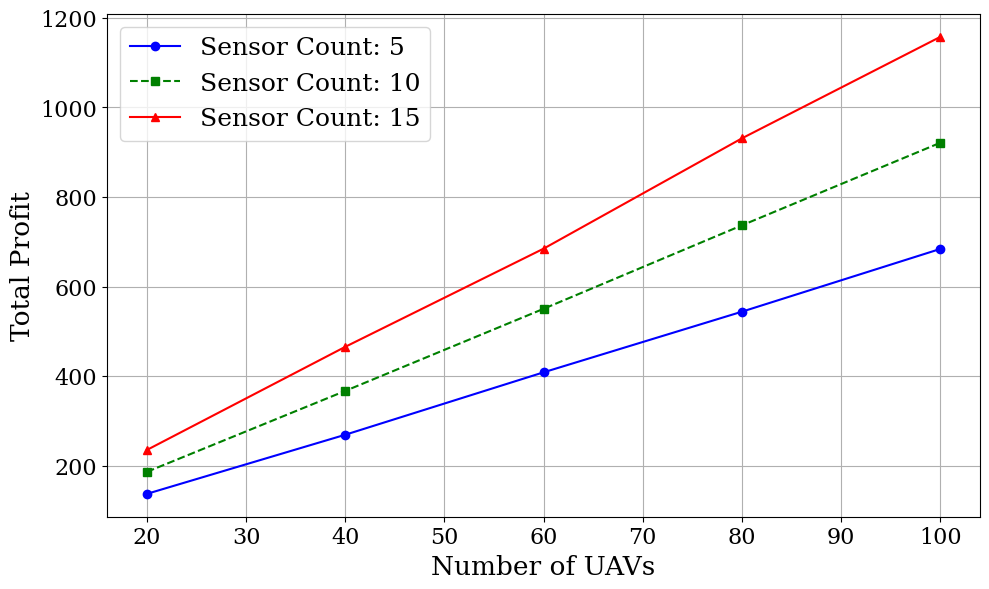

In [24]:


# We will now be able to provide better services so total profit increases too with no of uavs
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Attempt to set "Times New Roman" font
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman'] + rcParams['font.serif']

# Load the data from the Excel file
file_path = '/content/drive/MyDrive/MTP/Results/Paper_1/NewResults/output_100Trials.xlsx'
df = pd.read_excel(file_path, sheet_name='Sheet_name_1')

# Convert columns to numeric if necessary
df[['Total Active UAV', 'Total Active Sensors', 'EC_k', 'Tcost', 'RC_k', 'SC']] = df[['Total Active UAV', 'Total Active Sensors', 'EC_k', 'Tcost', 'RC_k', 'SC']].apply(pd.to_numeric)

# Function to calculate total profit
def get_total_profit(total_chargeable_price, total_expense):
    return total_chargeable_price - total_expense

# Function to calculate total chargeable price
def get_total_chargeable_price(EC_k, Tcost, RC_k, SC):
    profit_margin = 0.1  # Example 10% profit margin
    return (EC_k + Tcost + RC_k + SC) * (1 + profit_margin)

# Filter data for sensor counts 5, 10, and 15
sensor_counts = [5, 10, 15]
colors = ['b', 'g', 'r']
patterns = ['o-', 's--', '^-']

# Create the plot
plt.figure(figsize=(10, 6))

for i, sensor_count in enumerate(sensor_counts):
    # Filter data for the current sensor count
    df_filtered = df[df['Total Active Sensors'] == sensor_count]

    # Aggregate data by the number of UAVs
    df_aggregated = df_filtered.groupby('Total Active UAV').agg({
        'EC_k': 'mean',
        'Tcost': 'mean',
        'RC_k': 'mean',
        'SC': 'mean'
    }).reset_index()

    # Filter data to include only UAVs up to 100
    df_aggregated = df_aggregated[df_aggregated['Total Active UAV'] <= 100]

    # Calculate total chargeable price and total profit
    df_aggregated['Total Chargeable Price'] = df_aggregated.apply(lambda row: get_total_chargeable_price(row['EC_k'], row['Tcost'], row['RC_k'], row['SC']), axis=1)
    df_aggregated['Total Expense'] = df_aggregated['EC_k'] + df_aggregated['Tcost'] + df_aggregated['RC_k'] + df_aggregated['SC']
    df_aggregated['Total Profit'] = df_aggregated.apply(lambda row: get_total_profit(row['Total Chargeable Price'], row['Total Expense']), axis=1)

    # Sort the data by the number of UAVs for a better line plot
    df_aggregated.sort_values(by='Total Active UAV', inplace=True)

    # Plot total profit with different colors and patterns
    plt.plot(df_aggregated['Total Active UAV'], df_aggregated['Total Profit'], patterns[i], color=colors[i], label=f'Sensor Count: {sensor_count}')

# Set plot title and labels

plt.xlabel('Number of UAVs', fontsize=19)
plt.ylabel('Total Profit', fontsize=19)
plt.legend(fontsize=18)

# Set tick labels font size
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


COMPARISON PART


In [14]:
import numpy as np
import pandas as pd

# Provided
X = [5,15]
N = [5,15]
ALPHA_SJ = [True,False]
BETA_UI = [True, False]
LAT = 20
LON = 20
ALT = 20
Vi = [1,20]
Vw = [1,20]
PVi = [5,15]
PHi = [5,15]
Ps = [5,15]
CPTr = 1
CPh = 2
DEL_CEtr = 2
DEL_CEh = 2
CEs = 0.5
Ct = 5
CPUi = 3
CPSj = 2
DEL_stopro = 1
ETAi = 1
GAMMA = 2

# Assumed
# Total number of trails
TRIALS_MAX = 10
# Number of tasks
K = [2,5]
# Time to hover - hour
Thi =  [0.05,2]
# Power component of hover
Phi = [5,10]
# Scan time for sensors
ScanT = [0.05, 2]
# Transmit energy to transmit scan data for sensors
TransmitE = 0.05
# Total time for time based - Hour
Total_Tt = [0.10, 6]
# Time taken by the UAV [0.10 to Total_Tt] - Hour
Taken_Tt = [0.10, 6]
# Total amount of data for Transmission and Storage in GB
D = [0.1, 10]
# Communication Likeness
Ti_Max = 10
Tp = [0,10]
CUi_Threshold = 0.4
# Covergence Likeness
Area_Tt = [5,15]
# 0 to Area_Tt
Area_Cov = [5,15]
# Cost per service charge
CSc = 1

Mu = [0.1,0.1,0.1,0.1,0.1,0.1]
PT_Max = 1000

"""As per the paper, We need to take 1000 observations of each combination of UAV and Sensors. For now let us take 10 such combinations and for each combination we will simulate the entire process and come up with the values. At the end of each computation we will store all the calculated and assumed values to the spreadsheet. This spreadsheet will be used later to help us draw the conclusive evidences.


"""

!pip install --upgrade pandas

import random
import math
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

class EnergyBasedVal:
  def __init__(self, EC_tr, EC_h, EC_s, Ec_K):
    self.EC_tr = EC_tr
    self.EC_h = EC_h
    self.EC_s = EC_s
    self.Ec_K = Ec_K

class TimeBasedVal:
  def __init__(self,Tcost):
    self.Tcost = Tcost

class ResourceBasedVal:
  def __init__(self,active_uav_count,active_sensors_count,HMCu,HMCs,HMCk,total_d,Ccom,Cstopro,Rc_K):
    self.active_uav_count = active_uav_count
    self.active_sensors_count = active_sensors_count
    self.HMCu = HMCu
    self.HMCs = HMCs
    self.HMCk = HMCk
    self.total_d = total_d
    self.Ccom = Ccom
    self.Cstopro = Cstopro
    self.Rc_K = Rc_K

class ReputationBasedVal:
  def __init__(self,SC):
    self.SC = SC



def get_energy_based_cost(x,n,uav_tasks_data):
  summation_tasks = sum(uav_tasks_data)
# for UAVs
  EC_tr_sum = 0
  EC_h_sum = 0
  for each_uav in range(0,x):
    lon_f = random.randint(0,LON)
    lon_i = random.randint(0,lon_f)
    lat_f = random.randint(0,LAT)
    lat_i = random.randint(0,lat_f)
    alt_f = random.randint(0,ALT)
    alt_i = random.randint(0,alt_f)

    Di = math.sqrt(((lon_f - lon_i)**2) + ((lat_f - lat_i)**2) + ((alt_f - alt_i)**2))

    vi = random.randint(Vi[0],Vi[1])
    vw = random.randint(Vw[0],Vw[1])

    Vi_net = math.sqrt(2 * ((vi**2) + (vw**2)))
  #  transit state
    Ti_tr = Di/Vi_net
    pvi = random.randint(PVi[0],PVi[1])
    phi = random.randint(PHi[0],PHi[1])
    Ei_tr = Ti_tr * (pvi + phi)
    EC_tr_sum = EC_tr_sum + Ei_tr

  #  hover state
    time_hi = random.uniform(Thi[0], Thi[1])
    power_hi = random.randint(Phi[0], Phi[1])
    Ei_h = time_hi * power_hi
    EC_h_sum = EC_h_sum + Ei_h

  EC_tr = (EC_tr_sum *  CPTr) -  (summation_tasks * DEL_CEtr)
  EC_h = (EC_h_sum *  CPh) -  (summation_tasks * DEL_CEh)

# for Sensors
  EC_s = 0
  for curr_uav_index in range(0, x):
    # check if curr UAV is being utilized
    Es_sum = 0
    curr_uav_active_sensors_count = random.randint(0,n)
    for curr_uav_curr_sensor in range(0, curr_uav_active_sensors_count):
      # check if the sensor is being utilized
      scant = random.uniform(ScanT[0],ScanT[1])
      ps = random.randint(Ps[0],Ps[1])
      transmit_energy = TransmitE
      Es_j = ((scant * ps) + transmit_energy)
      Es_sum = Es_sum + Es_j
    EC_s = EC_s + Es_sum
  EC_s = EC_s *  CEs

  Ec_K = EC_tr + EC_h + EC_s
  energy_based_vals = EnergyBasedVal(EC_tr, EC_h, EC_s, Ec_K)
  return energy_based_vals

def get_time_based_cost(x):
  Tcost_sum = 0
  for each_uav in range(0, x):
    total_time = random.uniform(Total_Tt[0], Total_Tt[1])
    taken_time = random.uniform(Taken_Tt[0], total_time)
    Tprod_i = taken_time/total_time
    Tcost_sum = Tcost_sum + Tprod_i
  Tcost = Tcost_sum * Ct
  time_based_vals = TimeBasedVal(Tcost)
  return time_based_vals

def get_resource_based_cost(x,n):
  # hardware maintenance cost

  # for UAV
  # Simply count the number of active UAVs and multiply that number with CPUi
  active_uav_count = x
  HMCu = x * CPUi

  # for Sensors
  # Count the active sensors in each UAV and multiply it with CPSj. Repeat it for all the UAV and then take the accumulation of values for all UAVs
  active_sensors_count = n
  HMCs = active_sensors_count * CPSj

  HMCk = HMCu + HMCs

  # communication AND storage and processing cost
  total_d = 0
  for each_uav in range(0,x):
    curr_uav_d = random.uniform(D[0],D[1])
    total_d = total_d + curr_uav_d

  Ccom = ETAi * total_d
  Cstopro = DEL_stopro * total_d


  Rc_K = HMCk + Ccom + Cstopro
  resource_based_vals = ResourceBasedVal(active_uav_count,active_sensors_count,HMCu,HMCs,HMCk,total_d,Ccom,Cstopro,Rc_K)
  return resource_based_vals

def get_reputation_based_cost_v2(x,n):
  total_feedbacks = Ti_Max
  total_positive_feedback_count = 0
  # ComRF
  uav_reputation_coff = 0
  for each_uav in range(0,x):
    uav_positive_feedback_count = random.randint(Tp[0],total_feedbacks)
    # total_positive_feedback_count = total_positive_feedback_count + uav_positive_feedback_count
    ComRF = uav_positive_feedback_count/total_feedbacks

    # print("COMRF 2: ",ComRF)
    # CovRF
    CovRF_bar = 0
    curr_uav_active_sensor_count = random.randint(1,n)
    curr_uav_CovRF = 0
    for each_sensor_curr_uav in range(0, curr_uav_active_sensor_count):
      total_cov_area = random.randint(Area_Tt[0],Area_Tt[1])
      actual_cov_area = random.randint(Area_Cov[0], total_cov_area)
      CovRF_j = actual_cov_area / total_cov_area
      # print(f"CovRF 2 for sensor {each_sensor_curr_uav} in UAV {each_uav} is {CovRF_j}")
      curr_uav_CovRF = curr_uav_CovRF + CovRF_j

    CovRF_bar = curr_uav_CovRF/curr_uav_active_sensor_count
    # print("COVRF 2 bar: ",CovRF_bar)

    Rep_factor = ComRF + CovRF_bar
    # print("Rep_factor 2: ",Rep_factor)

    total_time = random.uniform(Total_Tt[0], Total_Tt[1])
    taken_time = random.uniform(Taken_Tt[0], total_time)
    Tprod_i = taken_time/total_time

    # curr_uav_sensor_state_list = sensors_states[each_uav]
    # curr_active_sensors_count = curr_uav_sensor_state_list.count(True)
    curr_active_sensors_count = random.randint(1,n)

    curr_rep_coff = (Rep_factor * curr_active_sensors_count)/Tprod_i
    uav_reputation_coff = uav_reputation_coff + curr_rep_coff

  SC = CSc * (uav_reputation_coff)
  reputation_based_cost = ReputationBasedVal(SC)
  return reputation_based_cost

def get_CT_k(Ec_K,Tcost,Rc_K,SC):
  return (Ec_K + Tcost + Rc_K + SC)

def get_PT_k():
  coff = -1 * (1 + (Mu[5] * PT_Max))
  PT_k =  PT_Max * (10 ** coff)
  return PT_k

def get_optimal_CT_k(CT_k,PT_k):
  return (CT_k + PT_k)

# main function
# Create an empty dataframe with the desired columns
# main function
# Create an empty dataframe with the desired columns
columns = ['Total UAVs', 'Total Sensors', 'Total Active UAV', 'Total Active Sensors',
           'Energy_UAV_transit', 'Energy_UAV_hover', 'Energy_sensor', 'EC_k', 'Tcost',
            'HMCu', 'HMCs', 'HMCk', 'Total_Data',
           'Communication_cost', 'Storage_processing_cost', 'RC_k', 'SC', 'Cost Price']

excel_data = []
res_excel_data = []

res_columns = ['Total Active UAV','Total Active Sensors', 'EC_k', 'Tcost', 'RC_k', 'SC', 'Cost Price']

# For 100 such combinations of the values
for itr in range(0, 100):
  # come up with set of N-UAV
  # k = random.randint(K[0],K[1])
  # come up with set of F-UAV
  # j = random.randint(J[0],J[1])
  # come up with sensor count in each UAV Set
  X = [20,40,60,80,100,120,150]
  N = [5,10,15,20,25]
  uav_tasks_data = []
  for x in X:
    k = random.randint(K[0],K[1])
    uav_tasks_data.append(k)
    for n in N:
      print(f"Number of Active UAVs: {x} \t Number of Active Sensors: {n} \t")
      Ec_K_obj = get_energy_based_cost(x,n,uav_tasks_data)
      print(f"1. Energy Based Cost for {x} UAVs with {n} is: {Ec_K_obj.Ec_K}")
      Tcost_obj = get_time_based_cost(x)
      print(f"2. Time Based Cost for {x} UAVs with {n} is: {Tcost_obj.Tcost}")
      Rc_K_obj = get_resource_based_cost(x,n)
      print(f"3. Resource Based Cost for {x} UAVs with {n} is: {Rc_K_obj.Rc_K}")
      # SC_obj_1 = get_reputation_based_cost_v1(x,sensors_data,uav_states,sensors_states)
      # print(f"4. Reputation Based Cost 1 for {x} UAVs with {sensors_data} is: {SC_obj_1.SC}")
      SC_obj = get_reputation_based_cost_v2(x,n)
      print(f"4. Reputation Based Cost for {x} UAVs with {n} is: {SC_obj.SC}")
      CostPrice_Tk = get_CT_k(Ec_K_obj.Ec_K,Tcost_obj.Tcost,Rc_K_obj.Rc_K,SC_obj.SC)
      # Outputs
      Profit_Tk = get_PT_k()
      optimal_CostPrice_Tk = get_optimal_CT_k(CostPrice_Tk,Profit_Tk)
      print(f"Outputs: \n Profit_Tk: {Profit_Tk} \t Optimal_CostPrice_Tk: {optimal_CostPrice_Tk}")


      excel_data.append({'Total Active UAV':x,'Total Active Sensors':n, 'EC_k':Ec_K_obj.Ec_K, 'Tcost':Tcost_obj.Tcost, 'RC_k':Rc_K_obj.Rc_K, 'SC':SC_obj.SC, 'Cost Price':optimal_CostPrice_Tk})


df = pd.DataFrame(excel_data)
# # Save the dataframe to an Excel or CSV file
# writer = pd.ExcelWriter('output.xlsx', engine='openpyxl', mode='a')
# df.to_excel(writer, sheet_name='Sheet1')

with pd.ExcelWriter('/content/drive/MyDrive/MTP/Results/Paper_1/NewResults/output_100Trials.xlsx',
                    mode='w') as writer:
    df.to_excel(writer, sheet_name='Sheet_name_1', index=False)

import pandas as pd

# Load the Excel file
file_path = '/content/drive/MyDrive/MTP/Results/Paper_1/NewResults/output_100Trials.xlsx'
df = pd.read_excel(file_path, sheet_name='Sheet_name_1')

# Display the DataFrame


# Commented out IPython magic to ensure Python compatibility.
import matplotlib.pyplot as plt
import pandas as pd
# %matplotlib inline
# Set default font to Times New Roman for all text elements
plt.rcParams['font.family'] = 'Times New Roman'

res_df = pd.read_excel("/content/drive/MyDrive/MTP/Results/Paper_1/NewResults/output_100Trials.xlsx", sheet_name = "Sheet_name_1")




#second paper start

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
l1 = 2
l2 = 7
l3 = 11
M = 2
L = 12
n = 25
Ch = 2
μ1 = 50
σ = 5.77
δ = [40, 60]
alpha = 0.5  # Assume an alpha parameter for energy calculation
beta = 0.1  # Assume a beta parameter for expected total profit(10% Profit margin in optimal service paper too)

class UAVService:
    def __init__(self, K):
        self.K = K  # Number of UAVs

    def calculate_service(self):
        # Service calculation (using parameters l1, l2, l3, and K)
        return l1 * (self.K) + l2 * np.log(self.K + 1) + l3

class Energy:
    def __init__(self, K):
        self.K = K

    def calculate_energy(self):
        # Energy calculation (using parameters M, L, K, alpha)
        return M * (self.K) + L + alpha * np.sqrt(self.K)

class TravelCost:
    def __init__(self, K):
        self.K = K

    def calculate_travel_cost(self):
        # Travel cost calculation (using parameters n and K)
        return n * np.sqrt(self.K)

class ChargingCostPaid:
    def __init__(self, K):
        self.K = K

    def calculate_charging_cost_paid(self):
        # Charging cost paid calculation (using parameter Ch)
        return Ch * self.K

class ExpectedTotalProfit:
    def __init__(self, K):
        self.K = K

    def calculate_expected_total_profit(self, service_cost, energy_cost, travel_cost, charging_cost_paid):
        # Expected total profit calculation (using μ1, σ, K, beta)
        revenue = np.random.normal(μ1, σ, (self.K)).sum()
        costs = service_cost + energy_cost + travel_cost + charging_cost_paid
        return beta * (revenue - costs)

class Price:
    def __init__(self, K):
        self.K = K

    def calculate_price(self):
        # Price calculation (using μ1 and σ)
        return np.random.normal(μ1, σ, (self.K))

# Function to process dataframe
def process_dataframe(res_df):
    results = []
    for K, S in zip(res_df['Total Active UAV'], res_df['Total Active Sensors']):
        service = UAVService(K)
        energy = Energy(K)
        travel_cost = TravelCost(K)
        charging_cost_paid = ChargingCostPaid(K)
        expected_profit = ExpectedTotalProfit(K)
        price = Price(K)

        service_cost = service.calculate_service()
        energy_cost = energy.calculate_energy()
        travel_cost_value = travel_cost.calculate_travel_cost()
        charging_cost_paid_value = charging_cost_paid.calculate_charging_cost_paid()
        expected_total_profit_value = expected_profit.calculate_expected_total_profit(service_cost, energy_cost, travel_cost_value, charging_cost_paid_value)
        price_value = price.calculate_price()

        results.append({
            "Total Active UAV": K,
            "Total Active Sensors": S,
            "Service Cost": service_cost,
            "Energy Cost": energy_cost,
            "Travel Cost": travel_cost_value,
            "Charging Cost Paid": charging_cost_paid_value,
            "Expected Total Profit": expected_total_profit_value,
            "Price": price_value,
        })



    return pd.DataFrame(results)

# Assuming res1_df is a pandas dataframe with a column 'Total Active UAV'
# Load your res1_df dataframe here
# For example:
# res1_df = pd.read_csv('path_to_your_dataframe.csv')
file_path = '/content/drive/MyDrive/MTP/Results/Paper_1/NewResults/finalresult.xlsx'
res_df = pd.read_excel(file_path, sheet_name='Sheet_name_1')
# Process the dataframe
result_df = process_dataframe(res_df)








Streaming output truncated to the last 5000 lines.
Outputs: 
 Profit_Tk: 1.0000000000000001e-98 	 Optimal_CostPrice_Tk: 7183.1871686864215
Number of Active UAVs: 100 	 Number of Active Sensors: 10 	
1. Energy Based Cost for 100 UAVs with 10 is: 5471.372876951344
2. Time Based Cost for 100 UAVs with 10 is: 267.5805420463412
3. Resource Based Cost for 100 UAVs with 10 is: 1383.2549163025194
4. Reputation Based Cost for 100 UAVs with 10 is: 2282.434130193063
Outputs: 
 Profit_Tk: 1.0000000000000001e-98 	 Optimal_CostPrice_Tk: 9404.642465493267
Number of Active UAVs: 100 	 Number of Active Sensors: 15 	
1. Energy Based Cost for 100 UAVs with 15 is: 6707.1228227275715
2. Time Based Cost for 100 UAVs with 15 is: 285.9052055476811
3. Resource Based Cost for 100 UAVs with 15 is: 1217.9394839978395
4. Reputation Based Cost for 100 UAVs with 15 is: 3052.5434377414963
Outputs: 
 Profit_Tk: 1.0000000000000001e-98 	 Optimal_CostPrice_Tk: 11263.510950014588
Number of Active UAVs: 100 	 Number of Act

In [15]:
import pandas as pd
import numpy as np

# Define your parameters
l1 = 2
l2 = 7
l3 = 11
M = 2
L = 12
n = 25
Ch = 2
μ1 = 50
σ = 5.77
alpha = 0.5  # Assume an alpha parameter for energy calculation
beta = 0.1  # Assume a beta parameter for expected total profit

# Define classes
class UAVService:
    def __init__(self, K):
        self.K = K  # Number of UAVs

    def calculate_service(self):
        # Service calculation
        return l1 * self.K + l2 * np.log(self.K + 1) + l3

class Energy:
    def __init__(self, K):
        self.K = K

    def calculate_energy(self):
        # Energy calculation
        return M * self.K + L + alpha * np.sqrt(self.K)

class TravelCost:
    def __init__(self, K):
        self.K = K

    def calculate_travel_cost(self):
        # Travel cost calculation
        return n * np.sqrt(self.K)

class ChargingCostPaid:
    def __init__(self, K):
        self.K = K

    def calculate_charging_cost_paid(self):
        # Charging cost paid calculation
        return Ch * self.K

class ExpectedTotalProfit:
    def __init__(self, K):
        self.K = K

    def calculate_expected_total_profit(self, service_cost, energy_cost, travel_cost, charging_cost_paid):
        # Expected total profit calculation
        revenue = np.random.normal(μ1, σ, self.K).sum()
        costs = service_cost + energy_cost + travel_cost + charging_cost_paid
        return beta * (revenue - costs)

class Price:
    def __init__(self, K):
        self.K = K

    def calculate_price(self):
        # Price calculation
        return np.random.normal(μ1, σ, self.K)

# Function to process dataframe
def process_dataframe(res_df):
    results = []
    for K, S in zip(res_df['Total Active UAV'], res_df['Total Active Sensors']):
        service = UAVService(K)
        energy = Energy(K)
        travel_cost = TravelCost(K)
        charging_cost_paid = ChargingCostPaid(K)
        expected_profit = ExpectedTotalProfit(K)
        price = Price(K)

        service_cost = service.calculate_service()
        energy_cost = energy.calculate_energy()
        travel_cost_value = travel_cost.calculate_travel_cost()
        charging_cost_paid_value = charging_cost_paid.calculate_charging_cost_paid()
        expected_total_profit_value = expected_profit.calculate_expected_total_profit(service_cost, energy_cost, travel_cost_value, charging_cost_paid_value)
        price_value = price.calculate_price()

        results.append({
            "Total Active UAV": K,
            "Total Active Sensors": S,
            "Service Cost": service_cost,
            "Energy Cost": energy_cost,
            "Travel Cost": travel_cost_value,
            "Charging Cost Paid": charging_cost_paid_value,
            "Expected Total Profit": expected_total_profit_value,
            "Price": price_value,
        })

    return pd.DataFrame(results)

# Load the existing Excel file and specified sheet
file_path = '/content/drive/MyDrive/MTP/Results/Paper_1/NewResults/finalresult.xlsx'
res_df = pd.read_excel(file_path, sheet_name='Sheet_name_1')

# Process the dataframe to calculate new columns
new_columns_df = process_dataframe(res_df)

# Merge the new columns with the original dataframe
res_df = res_df.merge(new_columns_df[['Service Cost', 'Energy Cost', 'Travel Cost', 'Charging Cost Paid', 'Expected Total Profit']], left_index=True, right_index=True)

# Save the updated dataframe back to the Excel file
with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    res_df.to_excel(writer, sheet_name='Sheet_name_1', index=False)

print("Updated Excel sheet successfully!")


Updated Excel sheet successfully!


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import numpy as np
import pandas as pd

class UAVChargingModel:
    def __init__(self, Cuav, Luav, Cg, Qg, eta_uav):
        self.Cuav = Cuav
        self.Luav = Luav
        self.Cg = Cg
        self.Qg = Qg
        self.eta_uav = eta_uav
        self.F_values = {1: 5, 2: 10, 3: 15}  # Mapping for Fi,t values based on energy thresholds

    def charging_power(self, r_it, H1, H2):
        if r_it > H1:
            return self.F_values[1]
        elif H1 > r_it > H2:
            return self.F_values[2]
        else:
            return self.F_values[3]

    def charging_cost(self):
        ku = self.Cuav / self.Luav
        kg = self.Cg / self.Qg
        return ku, kg

    def total_profit(self, total_revenue, total_cost):
        return total_revenue - total_cost


class SensorNode:
    def __init__(self, Gs, Gr_i, eta_i, Lp, lambd, z_i, B_i, r_io, e_i):
        self.Gs = Gs
        self.Gr_i = Gr_i
        self.eta_i = eta_i
        self.Lp = Lp
        self.lambd = lambd
        self.z_i = z_i
        self.B_i = B_i
        self.r_io = r_io
        self.e_i = e_i

    def reception_power(self, F_it):
        Pi_t = (F_it * self.Gs * self.Gr_i * self.eta_i) / (self.Lp * (4 * 3.14 * self.z_i / self.lambd) ** 2)
        return Pi_t

    def residual_energy(self, t, Mi_t, Tt):
        r_it = self.r_io - (t + Mi_t / Tt - 1) * self.e_i
        return r_it


class ChargingSimulation:
    def __init__(self, Cc, T):
        self.Cc = Cc
        self.T = T
        self.Tt = Cc / T

    def move_time(self, d_t, epsilon_i, V):
        Mi_t = self.Tt * (d_t + epsilon_i / V * self.Tt - 1)
        return Mi_t

    def total_revenue(self, charging_matrix, D_it, C_i):
        I, T = charging_matrix.shape
        R_total = 0
        for i in range(I):
            for t in range(T):
                if charging_matrix[i, t] == 1:
                    R_total += D_it[i, t] * C_i[i]
        return R_total

    def total_cost(self, uav_model, uav_numbers, energy_usage):
        ku, kg = uav_model.charging_cost()
        total_cost = 0
        for uav_number in uav_numbers:
            total_cost += uav_number * (ku + kg * energy_usage)
        return total_cost


def load_uav_data(file_path):
    df = pd.read_csv(file_path)
    return df


# Load the data from the Excel file
file_path = '/content/drive/MyDrive/MTP/Results/Paper_1/NewResults/output_100Trials.xlsx'
res_df = pd.read_excel(file_path, sheet_name='Sheet_name_1')

# Example Usage
uav_model = UAVChargingModel(Cuav=100, Luav=3600, Cg=50, Qg=10000, eta_uav=0.9)  # Adjusted Cuav and Cg values
sensor_node = SensorNode(Gs=1.0, Gr_i=1.0, eta_i=0.8, Lp=0.9, lambd=0.125, z_i=10, B_i=100, r_io=50, e_i=1.5)
charging_simulation = ChargingSimulation(Cc=600, T=10)

# Assuming `res_df` is a DataFrame containing the necessary data
uav_numbers = res_df['Total Active UAV'].values

# Define the charging matrix, D_it, and C_i with example data
charging_matrix = np.random.randint(0, 2, size=(5, 10))  # Example: 5 sensor nodes, 10 time slots
D_it = np.random.rand(5, 10) * 100  # Increase revenue per unit charge significantly
C_i = np.random.rand(5) * 50  # Increase charging cost per unit charge

# Calculate total revenue and total cost
total_revenue = charging_simulation.total_revenue(charging_matrix, D_it, C_i)
energy_usage = 10  # Further adjusted placeholder for energy usage calculation
total_cost = charging_simulation.total_cost(uav_model, uav_numbers, energy_usage)

# Calculate total profit
total_profit = uav_model.total_profit(total_revenue, total_cost)
print(f"Total Profit: {total_profit}")


Total Profit: 32649.572449359875


In [21]:
import pandas as pd
import numpy as np

class UAVChargingService:
    def __init__(self, cost_uav, life_uav, cost_green_energy, capacity_green_energy, efficiency_uav, flying_power, hovering_power, charging_cycle):
        self.cost_uav = cost_uav
        self.life_uav = life_uav
        self.cost_green_energy = cost_green_energy
        self.capacity_green_energy = capacity_green_energy
        self.efficiency_uav = efficiency_uav
        self.flying_power = flying_power
        self.hovering_power = hovering_power
        self.charging_cycle = charging_cycle

    def ku(self):
        return self.cost_uav / self.life_uav

    def kg(self):
        return self.cost_green_energy / self.capacity_green_energy

    def travel_cost(self, distance, time_slot):
        return (self.ku() * (distance / time_slot) + distance) + self.energy_consumption(distance) * self.kg() / self.efficiency_uav

    def energy_consumption(self, distance):
        return distance * self.flying_power + self.hovering_power

    def total_cost(self, charging_data):
        total_cost = 0
        for i in range(len(charging_data)):
            for t in range(len(charging_data[i])):
                if charging_data[i][t]['charging'] == 1:
                    total_cost += self.travel_cost(distance=charging_data[i][t]['distance'], time_slot=charging_data[i][t]['time_slot'])
        return total_cost

    def total_revenue(self, charging_data):
        total_revenue = 0
        for i in range(len(charging_data)):
            for t in range(len(charging_data[i])):
                if charging_data[i][t]['charging'] == 1:
                    total_revenue += charging_data[i][t]['charging_time'] * charging_data[i][t]['charging_price']
        return total_revenue

    def total_profit(self, charging_data):
        return (self.total_revenue(charging_data) - self.total_cost(charging_data)) * 0.1

def generate_charging_data(k):
    # Generate realistic charging data based on k
    charging_data = []
    for i in range(k):
        num_charging_sessions = np.random.randint(1, 5)  # Random number of charging sessions for each UAV
        sessions = []
        for _ in range(num_charging_sessions):
            session = {
                'distance': np.random.uniform(5, 20),  # Random distance between 5 and 20 units
                'time_slot': 1,  # Assuming time slot is 1 for simplicity
                'charging_time': np.random.uniform(1, 3),  # Random charging time between 1 and 3 hours
                'charging_price': np.random.uniform(10, 50),  # Random charging price between 10 and 50 units
                'charging': 1  # Indicating the UAV is charging
            }
            sessions.append(session)
        charging_data.append(sessions)
    return charging_data

# Example usage with some dummy data
cost_uav = 10000
life_uav = 100000
cost_green_energy = 5000
capacity_green_energy = 1000000
efficiency_uav = 0.8
flying_power = 100
hovering_power = 50
charging_cycle = 10

uav_service = UAVChargingService(cost_uav, life_uav, cost_green_energy, capacity_green_energy, efficiency_uav, flying_power, hovering_power, charging_cycle)

# Assuming res_df is already defined and contains the 'Total Active UAV' and 'Total Active Sensors' columns
# If not, define it here with values up to 150 for 'Total Active UAV' and 25 for 'Total Active Sensors'
res_df = pd.DataFrame({
    'Total Active UAV': np.random.randint(1, 151, size=4500),  # Values between 1 and 150
    'Total Active Sensors': np.random.randint(1, 26, size=4500)  # Values between 1 and 25
})

def calculate_profit_for_uavs(res_df, uav_service):
    profits = []
    for i in range(len(res_df)):
        k = res_df.loc[i, 'Total Active UAV']
        sensors = res_df.loc[i, 'Total Active Sensors']
        charging_data = generate_charging_data(k)
        profit = uav_service.total_profit(charging_data) * sensors  # Adjust profit based on sensors
        profits.append(profit)
    res_df['Total Profit'] = profits
    return res_df

third_df = calculate_profit_for_uavs(res_df, uav_service)

# Adjust pandas display options
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Set the display width to None
pd.set_option('display.max_colwidth', None)  # Set the maximum column width to None

print(third_df)


      Total Active UAV  Total Active Sensors  Total Profit
0                  139                     7   9788.437420
1                  142                     2   2897.012687
2                   74                    18  12617.230371
3                  118                    19  20859.117586
4                   46                    18   8762.939352
5                  134                     1   1276.511270
6                   44                     7   3235.562290
7                  117                     8   8677.776890
8                  102                    21  20676.242075
9                  134                    21  25726.064237
10                   7                     9    588.670079
11                 102                     1    904.317895
12                  14                     7    708.700020
13                  18                    10   1937.941232
14                  50                    10   5076.531491
15                  38                     8   2935.6357

<ipython-input-19-137e82f72d45>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.sort_values(by='Total Active Sensors', inplace=True)


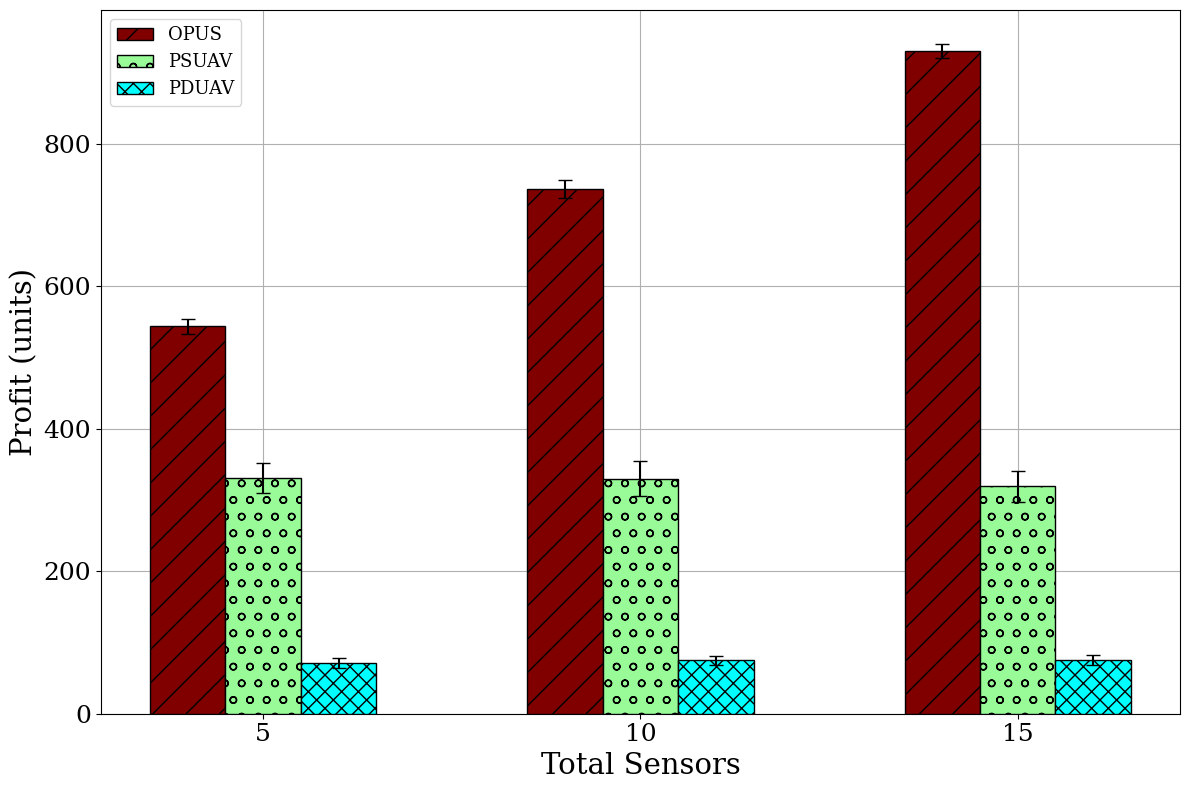

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import stats

# Attempt to set "Times New Roman" font
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman'] + rcParams['font.serif']

# Load the data from the Excel file
file_path = '/content/drive/MyDrive/MTP/Results/Paper_1/NewResults/output_100Trials.xlsx'
df = pd.read_excel(file_path, sheet_name='Sheet_name_1')

# Convert columns to numeric if necessary
df[['Total Active UAV', 'Total Active Sensors', 'EC_k', 'Tcost', 'RC_k', 'SC']] = df[['Total Active UAV', 'Total Active Sensors', 'EC_k', 'Tcost', 'RC_k', 'SC']].apply(pd.to_numeric)

# Filter data for UAVs = 80
df_filtered_uav = df[df['Total Active UAV'] == 80]

# Aggregate data by sensor counts
df_aggregated = df_filtered_uav.groupby('Total Active Sensors').agg({
    'Total Active UAV': 'mean',
    'EC_k': 'mean',
    'Tcost': 'mean',
    'RC_k': 'mean',
    'SC': 'mean'
}).reset_index()

# Calculate total chargeable price and total profit
def get_total_chargeable_price(EC_k, Tcost, RC_k, SC):
    profit_margin = 0.1  # Example 10% profit margin
    return (EC_k + Tcost + RC_k + SC) * (1 + profit_margin)

def get_total_profit(total_chargeable_price, total_expense):
    return total_chargeable_price - total_expense

df_aggregated['Total Chargeable Price'] = df_aggregated.apply(lambda row: get_total_chargeable_price(row['EC_k'], row['Tcost'], row['RC_k'], row['SC']), axis=1)
df_aggregated['Total Expense'] = df_aggregated['EC_k'] + df_aggregated['Tcost'] + df_aggregated['RC_k'] + df_aggregated['SC']
df_aggregated['Total Profit'] = df_aggregated.apply(lambda row: get_total_profit(row['Total Chargeable Price'], row['Total Expense']), axis=1)

# Filter data for specific sensor counts (5, 10, 15)
sensor_counts = [5, 10, 15]
df_filtered = df_aggregated[df_aggregated['Total Active Sensors'].isin(sensor_counts)]
df_filtered.sort_values(by='Total Active Sensors', inplace=True)

# Calculate PSUAV (expected total profit)
class ExpectedTotalProfit:
    def __init__(self, K):
        self.K = K

    def calculate_expected_total_profit(self, service_cost, energy_cost, travel_cost, charging_cost_paid):
        μ1 = 50
        σ = 5.77
        beta = 0.1
        revenue = np.random.normal(μ1, σ, self.K).sum()
        costs = service_cost + energy_cost + travel_cost + charging_cost_paid
        return beta * (revenue - costs)

class UAVService:
    def __init__(self, K):
        self.K = K  # Number of UAVs

    def calculate_service(self):
        l1 = 2
        l2 = 7
        l3 = 11
        return l1 * self.K + l2 * np.log(self.K + 1) + l3

class Energy:
    def __init__(self, K):
        self.K = K

    def calculate_energy(self):
        M = 2
        L = 12
        alpha = 0.5
        return M * self.K + L + alpha * np.sqrt(self.K)

class TravelCost:
    def __init__(self, K):
        self.K = K

    def calculate_travel_cost(self):
        n = 25
        return n * np.sqrt(self.K)

class ChargingCostPaid:
    def __init__(self, K):
        self.K = K

    def calculate_charging_cost_paid(self):
        Ch = 2
        return Ch * self.K

results = []
for sensors in sensor_counts:
    K = 80  # Fixed number of UAVs
    service = UAVService(K)
    energy = Energy(K)
    travel_cost = TravelCost(K)
    charging_cost_paid = ChargingCostPaid(K)
    expected_profit = ExpectedTotalProfit(K)

    service_cost = service.calculate_service()
    energy_cost = energy.calculate_energy()
    travel_cost_value = travel_cost.calculate_travel_cost()
    charging_cost_paid_value = charging_cost_paid.calculate_charging_cost_paid()
    expected_total_profit_value = expected_profit.calculate_expected_total_profit(service_cost, energy_cost, travel_cost_value, charging_cost_paid_value)

    results.append({
        "Total Active Sensors": sensors,
        "Expected Total Profit": expected_total_profit_value
    })

psuav_df = pd.DataFrame(results)
psuav_df.sort_values(by='Total Active Sensors', inplace=True)

# Calculate PDUAV (total profit without detailed simulation)
np.random.seed(32)

class UAVChargingService:
    def __init__(self, cost_uav, life_uav, cost_green_energy, capacity_green_energy, efficiency_uav, flying_power, hovering_power, charging_cycle):
        self.cost_uav = cost_uav
        self.life_uav = life_uav
        self.cost_green_energy = cost_green_energy
        self.capacity_green_energy = capacity_green_energy
        self.efficiency_uav = efficiency_uav
        self.flying_power = flying_power
        self.hovering_power = hovering_power
        self.charging_cycle = charging_cycle

    def total_profit(self):
        avg_revenue = np.random.uniform(1000, 2000)  # average revenue
        avg_cost = np.random.uniform(500, 1000)  # average cost
        return (avg_revenue - avg_cost) * 0.1  # profit margin of 10%

uav_service = UAVChargingService(10000, 100000, 5000, 1000000, 0.8, 100, 50, 10)

def calculate_profit_for_sensors(sensor_counts, uav_service):
    profits = []
    for sensors in sensor_counts:
        total_profit = 0
        for _ in range(100):  # Calculate for 100 different configurations of UAVs
            total_profit += uav_service.total_profit()
        profits.append(total_profit / 100)  # Average profit across different configurations
    return pd.DataFrame({'Total Active Sensors': sensor_counts, 'Total Profit': profits})

third_df = calculate_profit_for_sensors(sensor_counts, uav_service)
third_df.sort_values(by='Total Active Sensors', inplace=True)

# Calculate 95% confidence intervals
def calculate_confidence_interval(data, confidence=0.95):
    n = len(data)
    m = np.mean(data)
    se = stats.sem(data)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

# Simulate data to calculate confidence intervals
def simulate_confidence_intervals(sensor_counts, uav_service):
    profits = []
    for sensors in sensor_counts:
        trial_profits = []
        for _ in range(100):  # 100 trials for confidence intervals
            trial_profits.append(uav_service.total_profit())
        profits.append(calculate_confidence_interval(trial_profits))
    return profits

# Calculate confidence intervals for PDUAV
pduav_conf_intervals = simulate_confidence_intervals(sensor_counts, uav_service)
pduav_means = [x[0] for x in pduav_conf_intervals]
pduav_errors = [x[2] - x[0] for x in pduav_conf_intervals]

# Assuming df_filtered and psuav_df have appropriate confidence intervals (to be calculated similarly if needed)
# Placeholder values for the sake of this example
opus_errors = np.random.uniform(10, 20, len(sensor_counts))
psuav_errors = np.random.uniform(15, 25, len(sensor_counts))

# Plotting
plt.figure(figsize=(12, 8))
index = np.arange(len(sensor_counts))
bar_width = 0.2  # Width of each bar

# FIRST PLOT: OPUS
plt.bar(index - bar_width, df_filtered['Total Profit'], bar_width, color='#800000', hatch='/', edgecolor='black', label='OPUS', zorder=3, yerr=opus_errors, capsize=5)

# SECOND PLOT: PSUAV
plt.bar(index, psuav_df['Expected Total Profit'], bar_width, color='palegreen', edgecolor='black', hatch='o', label='PSUAV', zorder=3, yerr=psuav_errors, capsize=5)

# THIRD PLOT: PDUAV
plt.bar(index + bar_width, third_df['Total Profit'], bar_width, color='cyan', edgecolor='black', hatch='xx', label='PDUAV', zorder=3, yerr=pduav_errors, capsize=5)

# Labels and legends
plt.xlabel('Total Sensors', fontsize=21)
plt.ylabel('Profit (units)', fontsize=21)
plt.xticks(index, sensor_counts, fontsize=18)
plt.yticks(fontsize=18)

plt.grid(True, zorder=0)
plt.legend(fontsize=13, loc='upper left')
plt.tight_layout()
plt.show()
